## Instalando as dependências necessárias e lendo os arquivos

In [1]:
!pip install -q pyspark
!pip install matplotlib
!pip install seaborn


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import coalesce, col, current_date, concat_ws, datediff,date_format, explode, lit, min, max, row_number, sum as spark_sum, to_date, when
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random


spark = SparkSession.builder.master("local[*]").appName("Colab").getOrCreate()

In [3]:
'''
Lendo cada arquivo individualmente
'''
df_offers = spark.read.json("data/raw/offers.json")
df_offers.show()

+--------------------+--------------+--------+--------------------+---------+-------------+
|            channels|discount_value|duration|                  id|min_value|   offer_type|
+--------------------+--------------+--------+--------------------+---------+-------------+
|[email, mobile, s...|            10|     7.0|ae264e3637204a6fb...|       10|         bogo|
|[web, email, mobi...|            10|     5.0|4d5c57ea9a6940dd8...|       10|         bogo|
|[web, email, mobile]|             0|     4.0|3f207df678b143eea...|        0|informational|
|[web, email, mobile]|             5|     7.0|9b98b8c7a33c4b65b...|        5|         bogo|
|        [web, email]|             5|    10.0|0b1e1539f2cc45b7b...|       20|     discount|
|[web, email, mobi...|             3|     7.0|2298d6c36e964ae4a...|        7|     discount|
|[web, email, mobi...|             2|    10.0|fafdcd668e3743c1b...|       10|     discount|
|[email, mobile, s...|             0|     3.0|5a8bc65990b245e5a...|        0|inf

In [4]:
df_profile = spark.read.json("data/raw/profile.json")
df_profile.show()

+---+-----------------+------+--------------------+-------------+
|age|credit_card_limit|gender|                  id|registered_on|
+---+-----------------+------+--------------------+-------------+
|118|             NULL|  NULL|68be06ca386d4c319...|     20170212|
| 55|         112000.0|     F|0610b486422d4921a...|     20170715|
|118|             NULL|  NULL|38fe809add3b4fcf9...|     20180712|
| 75|         100000.0|     F|78afa995795e4d85b...|     20170509|
|118|             NULL|  NULL|a03223e636434f42a...|     20170804|
| 68|          70000.0|     M|e2127556f4f64592b...|     20180426|
|118|             NULL|  NULL|8ec6ce2a7e7949b1b...|     20170925|
|118|             NULL|  NULL|68617ca6246f4fbc8...|     20171002|
| 65|          53000.0|     M|389bc3fa690240e79...|     20180209|
|118|             NULL|  NULL|8974fc5686fe429db...|     20161122|
|118|             NULL|  NULL|c4863c7985cf408fa...|     20170824|
|118|             NULL|  NULL|148adfcaa27d485b8...|     20150919|
| 58|     

In [5]:
df_transactions = spark.read.json("data/raw/transactions.json")
df_transactions.show()

+--------------------+--------------+---------------------+--------------------+
|          account_id|         event|time_since_test_start|               value|
+--------------------+--------------+---------------------+--------------------+
|78afa995795e4d85b...|offer received|                  0.0|{NULL, 9b98b8c7a3...|
|a03223e636434f42a...|offer received|                  0.0|{NULL, 0b1e1539f2...|
|e2127556f4f64592b...|offer received|                  0.0|{NULL, 2906b810c7...|
|8ec6ce2a7e7949b1b...|offer received|                  0.0|{NULL, fafdcd668e...|
|68617ca6246f4fbc8...|offer received|                  0.0|{NULL, 4d5c57ea9a...|
|389bc3fa690240e79...|offer received|                  0.0|{NULL, f19421c1d4...|
|c4863c7985cf408fa...|offer received|                  0.0|{NULL, 2298d6c36e...|
|2eeac8d8feae4a8ca...|offer received|                  0.0|{NULL, 3f207df678...|
|aa4862eba776480b8...|offer received|                  0.0|{NULL, 0b1e1539f2...|
|31dda685af34476ca...|offer 

## Explorando os dados

### Estatística Descritiva, Limpeza e Transformação dos dados

In [6]:
# exibindo as 5 primeiras linhas do dataframe
df_offers.show(5)

+--------------------+--------------+--------+--------------------+---------+-------------+
|            channels|discount_value|duration|                  id|min_value|   offer_type|
+--------------------+--------------+--------+--------------------+---------+-------------+
|[email, mobile, s...|            10|     7.0|ae264e3637204a6fb...|       10|         bogo|
|[web, email, mobi...|            10|     5.0|4d5c57ea9a6940dd8...|       10|         bogo|
|[web, email, mobile]|             0|     4.0|3f207df678b143eea...|        0|informational|
|[web, email, mobile]|             5|     7.0|9b98b8c7a33c4b65b...|        5|         bogo|
|        [web, email]|             5|    10.0|0b1e1539f2cc45b7b...|       20|     discount|
+--------------------+--------------+--------+--------------------+---------+-------------+
only showing top 5 rows



In [7]:
''' exibindo as dimensões do dataframe'''
df_offers.count(), len(df_offers.columns)

(10, 6)

In [8]:
''' exibindo os tipos de cada coluna do dataframe'''
df_offers.dtypes

[('channels', 'array<string>'),
 ('discount_value', 'bigint'),
 ('duration', 'double'),
 ('id', 'string'),
 ('min_value', 'bigint'),
 ('offer_type', 'string')]

In [9]:
'''
exibindo um resumo estatístico do dataframe; para cada coluna, tem-se a quantidade de linhas, a média dos valores, desvio padrão, e valores de máximo e mínimo
'''
df_offers.describe().show()

+-------+-----------------+------------------+--------------------+-----------------+-------------+
|summary|   discount_value|          duration|                  id|        min_value|   offer_type|
+-------+-----------------+------------------+--------------------+-----------------+-------------+
|  count|               10|                10|                  10|               10|           10|
|   mean|              4.2|               6.5|                NULL|              7.7|         NULL|
| stddev|3.583914681524163|2.3213980461973533|                NULL|5.831904586934796|         NULL|
|    min|                0|               3.0|0b1e1539f2cc45b7b...|                0|         bogo|
|    max|               10|              10.0|fafdcd668e3743c1b...|               20|informational|
+-------+-----------------+------------------+--------------------+-----------------+-------------+



In [10]:
'''
A coluna 'channels' contém uma lista, vou converter pra one hot encoding
'''
df_expanded = df_offers.select("id", explode("channels").alias("channel"))
df_onehot_encoding = df_expanded.groupBy("id").pivot("channel").agg(lit(1))
df_onehot_encoding = df_onehot_encoding.fillna(0)
df_onehot_encoding.show()


+--------------------+-----+------+------+---+
|                  id|email|mobile|social|web|
+--------------------+-----+------+------+---+
|0b1e1539f2cc45b7b...|    1|     0|     0|  1|
|4d5c57ea9a6940dd8...|    1|     1|     1|  1|
|9b98b8c7a33c4b65b...|    1|     1|     0|  1|
|f19421c1d4aa40978...|    1|     1|     1|  1|
|fafdcd668e3743c1b...|    1|     1|     1|  1|
|ae264e3637204a6fb...|    1|     1|     1|  0|
|5a8bc65990b245e5a...|    1|     1|     1|  0|
|2298d6c36e964ae4a...|    1|     1|     1|  1|
|2906b810c7d441179...|    1|     1|     0|  1|
|3f207df678b143eea...|    1|     1|     0|  1|
+--------------------+-----+------+------+---+



In [11]:
'''
Modificando o dataframe original para incluir as novas colunas
'''
df_offers_adjusted = df_offers.drop("channels").join(df_onehot_encoding, on="id", how="left")
df_offers_adjusted.show()


+--------------------+--------------+--------+---------+-------------+-----+------+------+---+
|                  id|discount_value|duration|min_value|   offer_type|email|mobile|social|web|
+--------------------+--------------+--------+---------+-------------+-----+------+------+---+
|ae264e3637204a6fb...|            10|     7.0|       10|         bogo|    1|     1|     1|  0|
|4d5c57ea9a6940dd8...|            10|     5.0|       10|         bogo|    1|     1|     1|  1|
|3f207df678b143eea...|             0|     4.0|        0|informational|    1|     1|     0|  1|
|9b98b8c7a33c4b65b...|             5|     7.0|        5|         bogo|    1|     1|     0|  1|
|0b1e1539f2cc45b7b...|             5|    10.0|       20|     discount|    1|     0|     0|  1|
|2298d6c36e964ae4a...|             3|     7.0|        7|     discount|    1|     1|     1|  1|
|fafdcd668e3743c1b...|             2|    10.0|       10|     discount|    1|     1|     1|  1|
|5a8bc65990b245e5a...|             0|     3.0|    

In [12]:
'''
Explorando os dados em df_profile
'''
df_profile.show(5)

+---+-----------------+------+--------------------+-------------+
|age|credit_card_limit|gender|                  id|registered_on|
+---+-----------------+------+--------------------+-------------+
|118|             NULL|  NULL|68be06ca386d4c319...|     20170212|
| 55|         112000.0|     F|0610b486422d4921a...|     20170715|
|118|             NULL|  NULL|38fe809add3b4fcf9...|     20180712|
| 75|         100000.0|     F|78afa995795e4d85b...|     20170509|
|118|             NULL|  NULL|a03223e636434f42a...|     20170804|
+---+-----------------+------+--------------------+-------------+
only showing top 5 rows



In [13]:
''' dimensões do dataframe '''
df_profile.count(), len(df_profile.columns)

(17000, 5)

In [14]:
''' verificando os tipos de cada coluna do dataframe '''
df_profile.dtypes

[('age', 'bigint'),
 ('credit_card_limit', 'double'),
 ('gender', 'string'),
 ('id', 'string'),
 ('registered_on', 'string')]

In [15]:
''' resumo estatístico do dataframe '''
df_profile.describe().show()

+-------+------------------+------------------+------+--------------------+--------------------+
|summary|               age| credit_card_limit|gender|                  id|       registered_on|
+-------+------------------+------------------+------+--------------------+--------------------+
|  count|             17000|             14825| 14825|               17000|               17000|
|   mean| 62.53141176470588|  65404.9915682968|  NULL|2.565638242424101E31|2.0167034234117646E7|
| stddev|26.738579945767256|21598.299410229436|  NULL|                NULL|  11677.499960793006|
|    min|                18|           30000.0|     F|0009655768c64bdeb...|            20130729|
|    max|               118|          120000.0|     O|ffff82501cea40309...|            20180726|
+-------+------------------+------------------+------+--------------------+--------------------+



In [16]:
'''
Vou ajustar o dados em 'registered_on' pra date
'''
df_profile = df_profile.withColumn("registered_on",to_date("registered_on", "yyyyMMdd"))
df_profile.show(5)

+---+-----------------+------+--------------------+-------------+
|age|credit_card_limit|gender|                  id|registered_on|
+---+-----------------+------+--------------------+-------------+
|118|             NULL|  NULL|68be06ca386d4c319...|   2017-02-12|
| 55|         112000.0|     F|0610b486422d4921a...|   2017-07-15|
|118|             NULL|  NULL|38fe809add3b4fcf9...|   2018-07-12|
| 75|         100000.0|     F|78afa995795e4d85b...|   2017-05-09|
|118|             NULL|  NULL|a03223e636434f42a...|   2017-08-04|
+---+-----------------+------+--------------------+-------------+
only showing top 5 rows



In [17]:
''' verificando a quantidade de ids únicos '''
shape_profile = df_profile.count()
unique_ids = df_profile.select("id").distinct().count()
shape_profile, unique_ids


(17000, 17000)

In [18]:
'''
Não há repetições de usuários, cada linha representa um único usuário
Verificando os valores nulos:
'''
df_profile.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_profile.columns]).show()

+---+-----------------+------+---+-------------+
|age|credit_card_limit|gender| id|registered_on|
+---+-----------------+------+---+-------------+
|  0|             2175|  2175|  0|            0|
+---+-----------------+------+---+-------------+



In [19]:
'''
Vemos que há o mesmo número de usuários com 'gender' e 'credit_card_limit' nulos, vamos ver se eles tem os mesmos 'id':
'''
df_profile_nulls = df_profile.filter(col("gender").isNull() & col("credit_card_limit").isNull())
print(f'Numero de registros em que genero e limite do cartão estão nulos: {df_profile_nulls.count()}.\nPorcentagem em relacao ao numero total de usuarios: {df_profile_nulls.count()/df_profile.count()}')

Numero de registros em que genero e limite do cartão estão nulos: 2175.
Porcentagem em relacao ao numero total de usuarios: 0.12794117647058822


In [20]:
'''
Vemos que são as mesmos registros e que eles não representam uma parte tão grande do dataset. No entanto,
ao mesmo tempo que não é uma parte tão grande do dataset para remover, acredito ser uma porção grande para imputar valores, pode introduzir ruído.
Antes de decidir se vou apagar esses registros, vou dar uma olhada nos valores das outras colunas.
'''
df_profile_nulls.show(5)

+---+-----------------+------+--------------------+-------------+
|age|credit_card_limit|gender|                  id|registered_on|
+---+-----------------+------+--------------------+-------------+
|118|             NULL|  NULL|68be06ca386d4c319...|   2017-02-12|
|118|             NULL|  NULL|38fe809add3b4fcf9...|   2018-07-12|
|118|             NULL|  NULL|a03223e636434f42a...|   2017-08-04|
|118|             NULL|  NULL|8ec6ce2a7e7949b1b...|   2017-09-25|
|118|             NULL|  NULL|68617ca6246f4fbc8...|   2017-10-02|
+---+-----------------+------+--------------------+-------------+
only showing top 5 rows



In [21]:
''' verificando os valores para a coluna 'age' '''
df_profile_nulls.groupBy("age").count().orderBy("count", ascending=False).show()

+---+-----+
|age|count|
+---+-----+
|118| 2175|
+---+-----+



In [22]:
''' verificando os valores para a coluna 'registered_on' '''
df_profile_nulls.groupBy("registered_on").count().orderBy("count", ascending=False).show(10)

+-------------+-----+
|registered_on|count|
+-------------+-----+
|   2017-09-01|   11|
|   2017-10-02|    9|
|   2017-11-26|    8|
|   2017-09-28|    8|
|   2017-09-07|    8|
|   2017-10-14|    7|
|   2017-12-25|    7|
|   2018-01-13|    7|
|   2017-12-04|    7|
|   2017-11-17|    7|
+-------------+-----+
only showing top 10 rows



In [23]:
'''
Nos casos em que 'gender' e 'credit_card_limit' são nulos, todos tem a mesma idade, 118 anos.
Parece ser uma idade um pouco alta, mas preciso comparar com o resto do dataset (usuários com 'gender' e 'credit_card_limit' não-nulos) pra ver se é um outlier mesmo.
'''
df_profile_non_nulls = df_profile.filter(col("gender").isNotNull() & col("credit_card_limit").isNotNull())
df_profile_non_nulls.describe("age").show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|             14825|
|   mean| 54.39352445193929|
| stddev|17.383705365855015|
|    min|                18|
|    max|               101|
+-------+------------------+



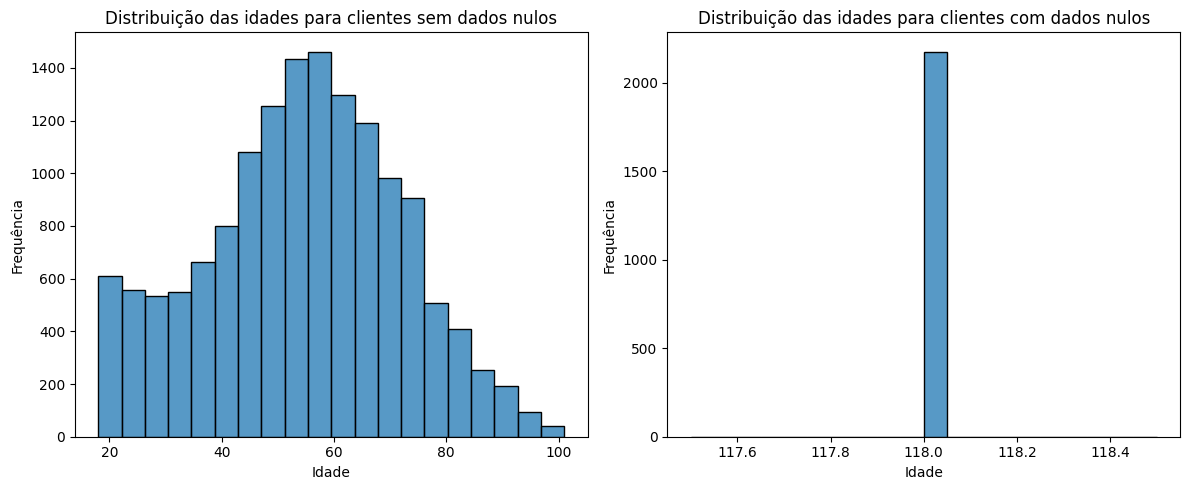

In [24]:
'''
Vou plotar a distribuição pra essas variáveis nos casos null e not_null para comparar.
'''
ages_non_null = df_profile_non_nulls.select("age").dropna().rdd.flatMap(lambda x: x).collect()
ages_null = df_profile_nulls.select("age").dropna().rdd.flatMap(lambda x: x).collect()


fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(ages_non_null, bins=20, ax=axs[0], kde=False)
axs[0].set_title("Distribuição das idades para clientes sem dados nulos")
axs[0].set_xlabel("Idade")
axs[0].set_ylabel("Frequência")

sns.histplot(ages_null, bins=20, ax=axs[1], kde=False)
axs[1].set_title("Distribuição das idades para clientes com dados nulos")
axs[1].set_xlabel("Idade")
axs[1].set_ylabel("Frequência")

plt.tight_layout()
plt.show()



In [25]:
"""
Comparando os graficos acima, podemos ver nos casos em que 'gender' e 'credit_card_limit' estão nulos, 'age' é sempre 118.
Um valor que não se encontra nos casos em que os dados de genero e credito estão preenchidos, o que indica que essa idade é um outlier.
Estou inclinada a apagar esses casos, mas antes, vou explorar melhor a coluna 'registered_on'.
"""
df_profile_nulls.select(min("registered_on").alias("min_date"),max("registered_on").alias("max_date"),
    spark_sum(when(col("registered_on").isNull(), 1).otherwise(0)).alias("null_dates")).show()

+----------+----------+----------+
|  min_date|  max_date|null_dates|
+----------+----------+----------+
|2013-08-02|2018-07-26|         0|
+----------+----------+----------+



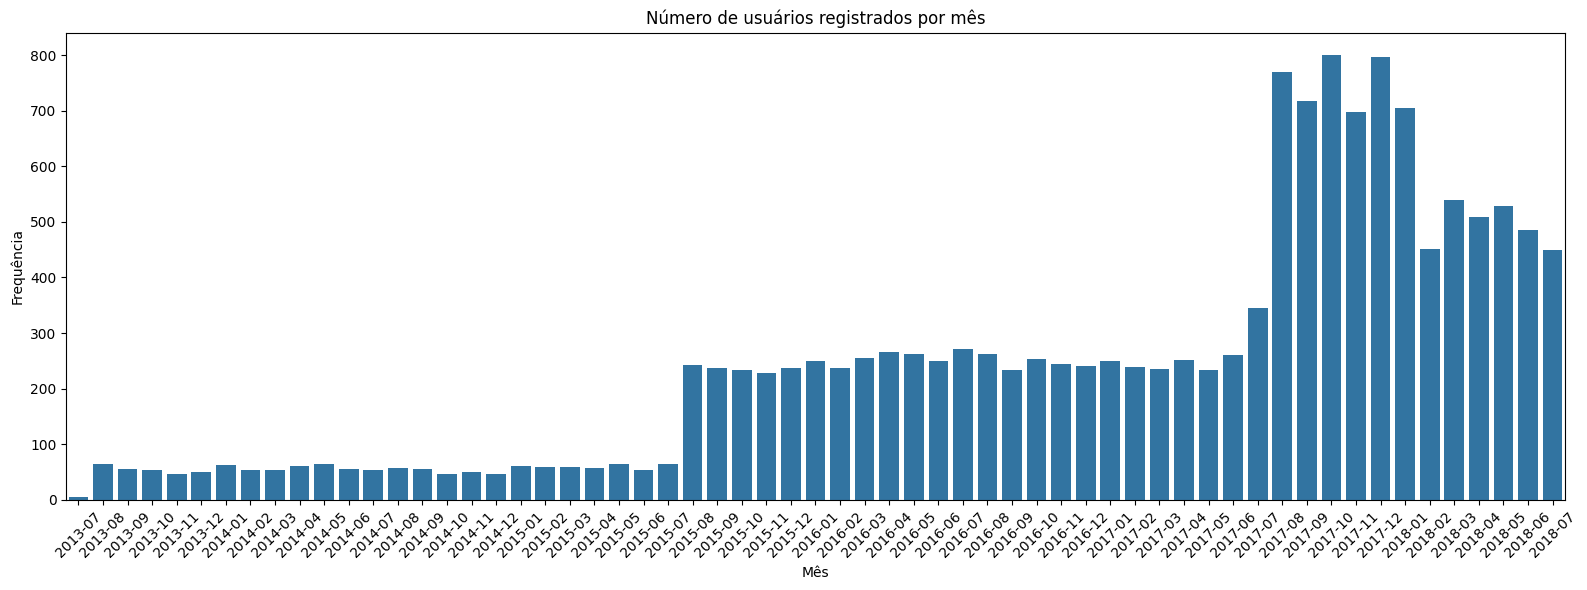

In [26]:
dates_non_null = df_profile_non_nulls
dates_non_null = dates_non_null.withColumn("month", date_format("registered_on", "yyyy-MM"))
df_monthly = dates_non_null.groupBy("month").count().orderBy("month")
data_pd = df_monthly.toPandas()

plt.figure(figsize=(16, 6))
sns.barplot(x="month", y="count", data=data_pd)
plt.xticks(rotation=45)
plt.title("Número de usuários registrados por mês")
plt.xlabel("Mês")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()



A coluna 'registered_on' parece estar preenchida corretamente, já que vemos uma boa variação nos dados. Ainda assim, 2175 registros ainda é um número alto para se inputar valores faltantes. Por isso, vou apagar esses registros.

Agora, vou olhar os dados dos usuários em que os campos 'gender' e 'credit_card_limit' não são nulos para obter insights sobre eles e fazer os tratamentos necessários.

In [27]:
''' exibindo as dimensões do dataframe '''
df_profile_non_nulls.count(),len(df_profile_non_nulls.columns)


(14825, 5)

In [28]:
'''
Agora temos 14825 usuários válidos. Verificando se há valores faltantes nas outras colunas:
'''
df_profile_non_nulls.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_profile_non_nulls.columns]).show()

+---+-----------------+------+---+-------------+
|age|credit_card_limit|gender| id|registered_on|
+---+-----------------+------+---+-------------+
|  0|                0|     0|  0|            0|
+---+-----------------+------+---+-------------+



In [29]:
'''
Para facilitar a visualização de há quanto tempo os usuários se registraram, vou criar uma coluna 'days_since_register' em que eu subtraio a data de registro do dia de hoje.
'''
df_profile_non_nulls = df_profile_non_nulls.withColumn("days_since_register",datediff(current_date(), col("registered_on")))
df_profile_non_nulls.describe().show()

+-------+------------------+------------------+------+--------------------+-------------------+
|summary|               age| credit_card_limit|gender|                  id|days_since_register|
+-------+------------------+------------------+------+--------------------+-------------------+
|  count|             14825|             14825| 14825|               14825|              14825|
|   mean| 54.39352445193929|  65404.9915682968|  NULL|2.565638242424101E31| 3028.4789881956153|
| stddev|17.383705365855015|21598.299410229436|  NULL|                NULL|  419.2051576820764|
|    min|                18|           30000.0|     F|0009655768c64bdeb...|               2506|
|    max|               101|          120000.0|     O|ffff82501cea40309...|               4329|
+-------+------------------+------------------+------+--------------------+-------------------+



In [30]:
''' exibindo uma pequena parte do dataframe '''
df_profile_non_nulls.show(5)

+---+-----------------+------+--------------------+-------------+-------------------+
|age|credit_card_limit|gender|                  id|registered_on|days_since_register|
+---+-----------------+------+--------------------+-------------+-------------------+
| 55|         112000.0|     F|0610b486422d4921a...|   2017-07-15|               2882|
| 75|         100000.0|     F|78afa995795e4d85b...|   2017-05-09|               2949|
| 68|          70000.0|     M|e2127556f4f64592b...|   2018-04-26|               2597|
| 65|          53000.0|     M|389bc3fa690240e79...|   2018-02-09|               2673|
| 58|          51000.0|     M|2eeac8d8feae4a8ca...|   2017-11-11|               2763|
+---+-----------------+------+--------------------+-------------+-------------------+
only showing top 5 rows



In [31]:
'''
Para preparar os dados para uso futuro em algum modelo, vou fazer one hot encoding da coluna 'gender'
'''
df_onehot_encoding_gender = df_profile_non_nulls.groupBy("id").pivot("gender").agg(lit(1))
df_onehot_encoding_gender = df_onehot_encoding_gender.fillna(0)
df_profile_non_nulls = df_profile_non_nulls.join(df_onehot_encoding_gender, on="id", how="left")
df_profile_non_nulls.show(5)

+--------------------+---+-----------------+------+-------------+-------------------+---+---+---+
|                  id|age|credit_card_limit|gender|registered_on|days_since_register|  F|  M|  O|
+--------------------+---+-----------------+------+-------------+-------------------+---+---+---+
|0610b486422d4921a...| 55|         112000.0|     F|   2017-07-15|               2882|  1|  0|  0|
|78afa995795e4d85b...| 75|         100000.0|     F|   2017-05-09|               2949|  1|  0|  0|
|e2127556f4f64592b...| 68|          70000.0|     M|   2018-04-26|               2597|  0|  1|  0|
|389bc3fa690240e79...| 65|          53000.0|     M|   2018-02-09|               2673|  0|  1|  0|
|2eeac8d8feae4a8ca...| 58|          51000.0|     M|   2017-11-11|               2763|  0|  1|  0|
+--------------------+---+-----------------+------+-------------+-------------------+---+---+---+
only showing top 5 rows



In [32]:
''' verificando a contagem de campos nulos depois das modificações '''
df_profile_non_nulls.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_profile_non_nulls.columns]).show()

+---+---+-----------------+------+-------------+-------------------+---+---+---+
| id|age|credit_card_limit|gender|registered_on|days_since_register|  F|  M|  O|
+---+---+-----------------+------+-------------+-------------------+---+---+---+
|  0|  0|                0|     0|            0|                  0|  0|  0|  0|
+---+---+-----------------+------+-------------+-------------------+---+---+---+



In [33]:
''' Explorando os dados de transação '''
df_transactions.show(5)

+--------------------+--------------+---------------------+--------------------+
|          account_id|         event|time_since_test_start|               value|
+--------------------+--------------+---------------------+--------------------+
|78afa995795e4d85b...|offer received|                  0.0|{NULL, 9b98b8c7a3...|
|a03223e636434f42a...|offer received|                  0.0|{NULL, 0b1e1539f2...|
|e2127556f4f64592b...|offer received|                  0.0|{NULL, 2906b810c7...|
|8ec6ce2a7e7949b1b...|offer received|                  0.0|{NULL, fafdcd668e...|
|68617ca6246f4fbc8...|offer received|                  0.0|{NULL, 4d5c57ea9a...|
+--------------------+--------------+---------------------+--------------------+
only showing top 5 rows



In [34]:
''' exibindo as dimensões do dataframe '''
df_transactions.count(), len(df_transactions.columns)

(306534, 4)

In [35]:
''' exibindo os tipos de cada coluna do dataframe '''
df_transactions.dtypes

[('account_id', 'string'),
 ('event', 'string'),
 ('time_since_test_start', 'double'),
 ('value',
  'struct<amount:double,offer id:string,offer_id:string,reward:double>')]

In [36]:
''' a coluna 'value' contém mais 4 dados em si '''
df_transactions.createOrReplaceTempView("transactions")
spark.sql("SELECT value FROM transactions LIMIT 5").show(truncate=False)

+----------------------------------------------------+
|value                                               |
+----------------------------------------------------+
|{NULL, 9b98b8c7a33c4b65b9aebfe6a799e6d9, NULL, NULL}|
|{NULL, 0b1e1539f2cc45b7b9fa7c272da2e1d7, NULL, NULL}|
|{NULL, 2906b810c7d4411798c6938adc9daaa5, NULL, NULL}|
|{NULL, fafdcd668e3743c1bb461111dcafc2a4, NULL, NULL}|
|{NULL, 4d5c57ea9a6940dd891ad53e9dbe8da0, NULL, NULL}|
+----------------------------------------------------+



In [37]:
'''
Criando uma coluna para cada um desses dados
'''
df_transactions = df_transactions.select("*", col("value.*"))
df_transactions = df_transactions.drop("value")
df_transactions.show(5)

+--------------------+--------------+---------------------+------+--------------------+--------+------+
|          account_id|         event|time_since_test_start|amount|            offer id|offer_id|reward|
+--------------------+--------------+---------------------+------+--------------------+--------+------+
|78afa995795e4d85b...|offer received|                  0.0|  NULL|9b98b8c7a33c4b65b...|    NULL|  NULL|
|a03223e636434f42a...|offer received|                  0.0|  NULL|0b1e1539f2cc45b7b...|    NULL|  NULL|
|e2127556f4f64592b...|offer received|                  0.0|  NULL|2906b810c7d441179...|    NULL|  NULL|
|8ec6ce2a7e7949b1b...|offer received|                  0.0|  NULL|fafdcd668e3743c1b...|    NULL|  NULL|
|68617ca6246f4fbc8...|offer received|                  0.0|  NULL|4d5c57ea9a6940dd8...|    NULL|  NULL|
+--------------------+--------------+---------------------+------+--------------------+--------+------+
only showing top 5 rows



In [38]:
''' resumo estatístico do dataframe '''
df_transactions.describe().show()

+-------+--------------------+---------------+---------------------+------------------+--------------------+--------------------+------------------+
|summary|          account_id|          event|time_since_test_start|            amount|            offer id|            offer_id|            reward|
+-------+--------------------+---------------+---------------------+------------------+--------------------+--------------------+------------------+
|  count|              306534|         306534|               306534|            138953|              134002|               33579|             33579|
|   mean|2.565638242424101E31|           NULL|   15.265955815668082| 12.77735615639814|                NULL|                NULL| 4.904136513892611|
| stddev|                 0.0|           NULL|    8.346929730115084|30.250528632017126|                NULL|                NULL|2.8866468823372804|
|    min|0009655768c64bdeb...|offer completed|                  0.0|              0.05|0b1e1539f2cc45b7b..

As novas colunas são 'amount', 'offer id', 'offer_id' e 'reward'. Para começar, vou verificar se os 'account_id' que aparecem nessa tabela são o mesmos de df_profile, e se as 'offer id' e 'offer_id' são as mesmas que aparecem em df_offers.

In [39]:
df_transactions.count(), df_transactions.select("account_id").distinct().count()

(306534, 17000)

Há dados de 306534 transações de 17000 usuários diferentes, mesmo número de df_profile antes de retirarmos os usuários com dados nulos. Verificando se são os mesmos usuários:

In [40]:
ids_profile = df_profile.select("id").distinct().rdd.flatMap(lambda x: x).collect()
ids_transactions = df_transactions.select("account_id").distinct().rdd.flatMap(lambda x: x).collect()
print(f'Interseção de usuários nas tabelas profile e transactions: {len(set(ids_profile) & set(ids_transactions))}')

Interseção de usuários nas tabelas profile e transactions: 17000


Tem os mesmos usuários que profile.json. Verificando se as ofertas são as mesmas que offers.json:

In [41]:
terms = ['offer id','offer_id']
ids_offers = df_offers_adjusted.select("id").distinct().rdd.flatMap(lambda x: x).collect()
print(f'Numero de ofertas distintas em df_offers: {len(ids_offers)}')
for term in terms:
  offers_ids_transactions = df_transactions.select(term).distinct().rdd.flatMap(lambda x: x).collect()
  print(f'Interseção de {term} nas tabelas offers e transactions: {len(set(ids_offers) & set(offers_ids_transactions))}')

Numero de ofertas distintas em df_offers: 10
Interseção de offer id nas tabelas offers e transactions: 10
Interseção de offer_id nas tabelas offers e transactions: 8


Há duas ofertas que aparecem em offers.json mas não aparecem na coluna offer_id em transactions.json. Explorando pra descobrir quais são e o porquê.


In [42]:
df_offers_adjusted.createOrReplaceTempView("offers")
df_transactions.createOrReplaceTempView("transactions")
result = spark.sql("SELECT o.id,o.offer_type FROM offers o LEFT ANTI JOIN transactions t ON o.id = t.offer_id")
result.show()

+--------------------+-------------+
|                  id|   offer_type|
+--------------------+-------------+
|5a8bc65990b245e5a...|informational|
|3f207df678b143eea...|informational|
+--------------------+-------------+



As ofertas do tipo *informational* não aparecem na coluna 'offer_id'. Analisando essa coluna pra saber qual a diferença dela para 'offer id'.


In [43]:
df_transactions.select([spark_sum(when(col("offer_id").isNull(), 1).otherwise(0)).alias("offer_id"),
    spark_sum(when(col("offer id").isNull(), 1).otherwise(0)).alias("offer id")]).show()

+--------+--------+
|offer_id|offer id|
+--------+--------+
|  272955|  172532|
+--------+--------+



Há muito mais valores nulos para offer_id do que 'offer id', mas ainda não consegui ver a diferença entre elas. Vou analisar por 'event' pra ver se ganho mais insight.

In [44]:
result = spark.sql("SELECT DISTINCT t.event FROM transactions t")
result.show()

+---------------+
|          event|
+---------------+
|    transaction|
| offer received|
|offer completed|
|   offer viewed|
+---------------+



Antes de proseguir, vou remover de df_transactions os usuários nulos para ficar apenas com os usuário presentes em df_profile_non_nulls.

In [45]:
df_transactions_non_nulls = df_transactions.join(df_profile_non_nulls.select("id").distinct(),df_transactions["account_id"] == df_profile_non_nulls["id"],how="inner")
df_transactions_non_nulls = df_transactions_non_nulls.drop('id')
df_transactions_non_nulls.show(5)

+--------------------+--------------+---------------------+------+--------------------+--------+------+
|          account_id|         event|time_since_test_start|amount|            offer id|offer_id|reward|
+--------------------+--------------+---------------------+------+--------------------+--------+------+
|78afa995795e4d85b...|offer received|                  0.0|  NULL|9b98b8c7a33c4b65b...|    NULL|  NULL|
|e2127556f4f64592b...|offer received|                  0.0|  NULL|2906b810c7d441179...|    NULL|  NULL|
|389bc3fa690240e79...|offer received|                  0.0|  NULL|f19421c1d4aa40978...|    NULL|  NULL|
|2eeac8d8feae4a8ca...|offer received|                  0.0|  NULL|3f207df678b143eea...|    NULL|  NULL|
|aa4862eba776480b8...|offer received|                  0.0|  NULL|0b1e1539f2cc45b7b...|    NULL|  NULL|
+--------------------+--------------+---------------------+------+--------------------+--------+------+
only showing top 5 rows



In [46]:
df_transactions_non_nulls.select("account_id").distinct().count(),df_profile_non_nulls.select("id").distinct().count()

(14825, 14825)

Agora que em df_transaction só tem transações de usuários válidos, vou prosseguir. Plotando a distribuição das ofertas:

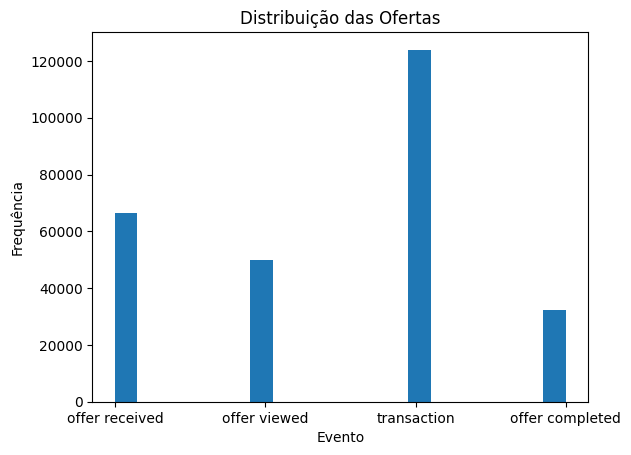

In [47]:
data_plot = df_transactions_non_nulls.select("event").rdd.flatMap(lambda x: x).collect()
plt.hist(data_plot, bins=20)
plt.xlabel("Evento")
plt.ylabel("Frequência")
plt.title("Distribuição das Ofertas")
plt.show()


Vemos que o evento mais popular é o do tipo 'transaction' e o menos popular é 'offer completed'. Para entender melhor a diferença entre cada oferta e transação, vou olhar cada evento individualmente.

In [48]:
df_offers_trans = df_transactions_non_nulls.filter(col("event") == "transaction")
df_offers_received = df_transactions_non_nulls.filter(col("event") == "offer received")
df_offers_viewed = df_transactions_non_nulls.filter(col("event") == "offer viewed")
df_offers_completed = df_transactions_non_nulls.filter(col("event") == "offer completed")
df_offers_trans.count(), df_offers_received.count(),df_offers_viewed.count(), df_offers_completed.count()

(123957, 66501, 49860, 32444)

In [49]:
''' verifcando os campos nulos em ofertas 'received' '''
df_offers_received.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)  for c in df_offers_received.columns]).show()

+----------+-----+---------------------+------+--------+--------+------+
|account_id|event|time_since_test_start|amount|offer id|offer_id|reward|
+----------+-----+---------------------+------+--------+--------+------+
|         0|    0|                    0| 66501|       0|   66501| 66501|
+----------+-----+---------------------+------+--------+--------+------+



In [50]:
''' verificando os campos nulos em ofertas 'vieweved' '''
df_offers_viewed.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)  for c in df_offers_viewed.columns]).show()

+----------+-----+---------------------+------+--------+--------+------+
|account_id|event|time_since_test_start|amount|offer id|offer_id|reward|
+----------+-----+---------------------+------+--------+--------+------+
|         0|    0|                    0| 49860|       0|   49860| 49860|
+----------+-----+---------------------+------+--------+--------+------+



In [51]:
''' verificando os campos nulos em ofertas 'completed' '''
df_offers_completed.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)  for c in df_offers_completed.columns]).show()

+----------+-----+---------------------+------+--------+--------+------+
|account_id|event|time_since_test_start|amount|offer id|offer_id|reward|
+----------+-----+---------------------+------+--------+--------+------+
|         0|    0|                    0| 32444|   32444|       0|     0|
+----------+-----+---------------------+------+--------+--------+------+



In [52]:
''' verificando os campos nulos em 'transaction' '''
df_offers_trans.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)  for c in df_offers_trans.columns]).show()

+----------+-----+---------------------+------+--------+--------+------+
|account_id|event|time_since_test_start|amount|offer id|offer_id|reward|
+----------+-----+---------------------+------+--------+--------+------+
|         0|    0|                    0|     0|  123957|  123957|123957|
+----------+-----+---------------------+------+--------+--------+------+



Para os eventos 'received' e 'viewed', os campos 'amount', 'offer_id' e 'reward' estão sempre nulos. Já para ofertas completas, os campos 'offer_id' e 'reward' são preenchidos. Portanto, o campo offer_id não nulo indica que uma oferta foi aceita. Dessa forma, como nenhuma oferta do tipo 'infomational' tem o campo 'offer_id' não nulo, podemos concluir que ofertas 'informational' só tem dois estados: 'received' e 'viewed'.

Analisando apenas as transações, os campos de offer id, offer_id e reward sempre estão nulos. Tem-se a informação do horário, valor e quem fez a transação. Ou seja, transações não tem referência a nenhuma oferta.

Para analisar melhor cada evento individualmente, vou ver quais tipos de oferta estão presentes em cada um. Antes, vou adicionar uma coluna em df_offers para que os nomes das ofertas fiquem mais legíveis.

In [53]:
df_offers = df_offers_adjusted.withColumn(
    "offer_name_adjusted",
    concat_ws("_",
        col("offer_type"),
        col("discount_value").cast("string"),
        col("min_value").cast("string"),
        col("duration").cast("int").cast("string")))
df_offers.show()

+--------------------+--------------+--------+---------+-------------+-----+------+------+---+-------------------+
|                  id|discount_value|duration|min_value|   offer_type|email|mobile|social|web|offer_name_adjusted|
+--------------------+--------------+--------+---------+-------------+-----+------+------+---+-------------------+
|ae264e3637204a6fb...|            10|     7.0|       10|         bogo|    1|     1|     1|  0|       bogo_10_10_7|
|4d5c57ea9a6940dd8...|            10|     5.0|       10|         bogo|    1|     1|     1|  1|       bogo_10_10_5|
|3f207df678b143eea...|             0|     4.0|        0|informational|    1|     1|     0|  1|informational_0_0_4|
|9b98b8c7a33c4b65b...|             5|     7.0|        5|         bogo|    1|     1|     0|  1|         bogo_5_5_7|
|0b1e1539f2cc45b7b...|             5|    10.0|       20|     discount|    1|     0|     0|  1|   discount_5_20_10|
|2298d6c36e964ae4a...|             3|     7.0|        7|     discount|    1|    

In [54]:
'''
Vendo os tipos de ofertas recebidas
'''
df_offers.createOrReplaceTempView("offers")
df_offers_received.createOrReplaceTempView("df_offers_received")
result = spark.sql("SELECT DISTINCT o.offer_type,o.offer_name_adjusted FROM offers o JOIN df_offers_received r ON o.id = r.`offer id`")
result.show()

+-------------+-------------------+
|   offer_type|offer_name_adjusted|
+-------------+-------------------+
|     discount|     discount_3_7_7|
|informational|informational_0_0_4|
|         bogo|       bogo_10_10_5|
|         bogo|         bogo_5_5_5|
|         bogo|         bogo_5_5_7|
|     discount|   discount_2_10_10|
|informational|informational_0_0_3|
|     discount|    discount_2_10_7|
|     discount|   discount_5_20_10|
|         bogo|       bogo_10_10_7|
+-------------+-------------------+



In [55]:
'''
Vendo os tipos de ofertas vistas
'''
df_offers_viewed.createOrReplaceTempView("df_offers_viewed")
result = spark.sql("SELECT DISTINCT o.offer_type,o.offer_name_adjusted FROM offers o JOIN df_offers_viewed v ON o.id = v.`offer id`")
result.show()

+-------------+-------------------+
|   offer_type|offer_name_adjusted|
+-------------+-------------------+
|     discount|     discount_3_7_7|
|informational|informational_0_0_4|
|         bogo|       bogo_10_10_5|
|         bogo|         bogo_5_5_5|
|         bogo|         bogo_5_5_7|
|     discount|   discount_2_10_10|
|informational|informational_0_0_3|
|     discount|    discount_2_10_7|
|     discount|   discount_5_20_10|
|         bogo|       bogo_10_10_7|
+-------------+-------------------+



In [56]:
'''
Vendo os tipos de ofertas completas
'''
df_offers_completed.createOrReplaceTempView("df_offers_completed")
result = spark.sql("SELECT DISTINCT o.offer_type,o.offer_name_adjusted FROM offers o JOIN df_offers_completed c ON o.id = c.`offer_id`")
result.show()

+----------+-------------------+
|offer_type|offer_name_adjusted|
+----------+-------------------+
|  discount|     discount_3_7_7|
|      bogo|       bogo_10_10_5|
|      bogo|         bogo_5_5_5|
|      bogo|         bogo_5_5_7|
|  discount|   discount_2_10_10|
|  discount|    discount_2_10_7|
|  discount|   discount_5_20_10|
|      bogo|       bogo_10_10_7|
+----------+-------------------+



#### Observações sobre as ofertas
Observa-se que a oferta do tipo 'Informational' só tem os estados 'received' e 'viewed', sem 'completed'. Ela também não tem valor mínimo para ativação, nem desconto, tendo carater apenas informativo.

Já as ofertas 'discount' e 'bogo' tem valor mínimo para ativação e desconto (reward) e podem ter os três estados 'received', 'viewed' e 'completed'.
O campo 'offer_id' é preenchido quando a oferta está no estado 'received' ou 'viewed', e quando a oferta é 'completed', o campo 'offer_id2' é preenchido, enquando 'offer_id' fica nulo.
Isso sugere que posso criar uma coluna extra chamada 'offer_succeeded' (ou algo assim), que terá valor 0 o 1 para indicar o sucesso da oferta.

Para entender melhor como as transações e as ofertas se relacionam, vou pegar o usuário com a maior quantidade de eventos e analisá-lo.

In [57]:
df_transactions_non_nulls.createOrReplaceTempView("transactions_non_nulls")
result = spark.sql("""
    SELECT account_id,COUNT(*) AS total FROM transactions_non_nulls GROUP BY account_id ORDER BY total DESC LIMIT 1""")
result.show()

+--------------------+-----+
|          account_id|total|
+--------------------+-----+
|94de646f7b6041228...|   51|
+--------------------+-----+



In [58]:
''' criando um dataframe apenas com os dados do usuário '94de646f7b6041228...' e ordenando os eventos de forma cronológica '''
user_test = df_transactions_non_nulls.filter(col("account_id") == result.collect()[0]['account_id'])
user_test = user_test.orderBy("time_since_test_start", ascending=True)
user_test = user_test.withColumn("offer_succeeded",when(col("offer_id").isNotNull(), 1).otherwise(0))
user_test = user_test.withColumn("offer",coalesce(col("offer_id"), col("offer id")))
user_test = user_test.drop('offer_id','offer id')


In [59]:
''' verificando todos os eventos relaciodos a um usuario '''
df_offers.createOrReplaceTempView("offers")
user_test.createOrReplaceTempView("user_test")
result = spark.sql(
"""
SELECT u.account_id, u.event,u.time_since_test_start as time_sent, u.amount,o.min_value,u.offer as offer_id, o.offer_type,
o.offer_name_adjusted as offer_name,u.reward,o.duration, u.offer_succeeded as completed FROM user_test u LEFT JOIN offers o ON o.id = u.offer""")
result.show(51)

+--------------------+---------------+---------+------+---------+--------------------+----------+----------------+------+--------+---------+
|          account_id|          event|time_sent|amount|min_value|            offer_id|offer_type|      offer_name|reward|duration|completed|
+--------------------+---------------+---------+------+---------+--------------------+----------+----------------+------+--------+---------+
|94de646f7b6041228...| offer received|      0.0|  NULL|        5|f19421c1d4aa40978...|      bogo|      bogo_5_5_5|  NULL|     5.0|        0|
|94de646f7b6041228...|   offer viewed|     0.25|  NULL|        5|f19421c1d4aa40978...|      bogo|      bogo_5_5_5|  NULL|     5.0|        0|
|94de646f7b6041228...|    transaction|     1.25|  7.41|     NULL|                NULL|      NULL|            NULL|  NULL|    NULL|        0|
|94de646f7b6041228...|offer completed|     1.25|  NULL|        5|f19421c1d4aa40978...|      bogo|      bogo_5_5_5|   5.0|     5.0|        1|
|94de646f7b60

Para esse usuário, vou analisar a cronologia das ofertas completas, verificando o momento em que foram recebidas, vistas e se houve transações até a oferta ser completada.

In [60]:
''' não usei SQL aqui porque eram dados de um usuário apenas, quando for gerar para todos, vou usar SQL '''
user_offers_completed = result.filter(col("completed") == 1)
completed_rows = user_offers_completed.collect()
schema = result.schema
for row in completed_rows:
    offer_id = row["offer_id"]
    time_offer_completed = row["time_sent"]
    duration_offer = row["duration"]

    offers_r = result.filter(
        (col("offer_id") == offer_id) &
        (col("event") == "offer received") &
        ((col("time_sent") <= time_offer_completed) &
        ((col("time_sent") + duration_offer) >= time_offer_completed))
    )


    offers_v = result.filter(
        (col("offer_id") == offer_id) &
        (col("event") == "offer viewed") &
        ((col("time_sent") >= offers_r.select("time_sent").first()["time_sent"]) &
        (col("time_sent") <= time_offer_completed))
    )


    trans_r = result.filter(
        (col("event") == "transaction") &
        ((col("time_sent") >= offers_r.select("time_sent").first()["time_sent"]) &
        (col("time_sent") <= time_offer_completed))
    )

    row_df = spark.createDataFrame([row.asDict()], schema=schema)
    all_offer = offers_r.union(offers_v).union(trans_r).union(row_df)
    all_offer.createOrReplaceTempView("offers_view")
    total = spark.sql("SELECT SUM(amount) AS total_amount FROM offers_view").collect()[0][0]
    print(f'Transações feitas no periodo da oferta: {total:.2f}, valor minimo para uso da oferta: {row["min_value"]}')
    all_offer.show()
    print('-'*100)

'''
Isso aqui demorou muito pra rodar (2 minutos), quando for fazer pra base toda, vou usar SQL mesmo.
'''

Transações feitas no periodo da oferta: 7.41, valor minimo para uso da oferta: 5
+--------------------+---------------+---------+------+---------+--------------------+----------+----------+------+--------+---------+
|          account_id|          event|time_sent|amount|min_value|            offer_id|offer_type|offer_name|reward|duration|completed|
+--------------------+---------------+---------+------+---------+--------------------+----------+----------+------+--------+---------+
|94de646f7b6041228...| offer received|      0.0|  NULL|        5|f19421c1d4aa40978...|      bogo|bogo_5_5_5|  NULL|     5.0|        0|
|94de646f7b6041228...|   offer viewed|     0.25|  NULL|        5|f19421c1d4aa40978...|      bogo|bogo_5_5_5|  NULL|     5.0|        0|
|94de646f7b6041228...|    transaction|     1.25|  7.41|     NULL|                NULL|      NULL|      NULL|  NULL|    NULL|        0|
|94de646f7b6041228...|offer completed|     1.25|  NULL|        5|f19421c1d4aa40978...|      bogo|bogo_5_5_5| 

'\nIsso aqui demorou muito pra rodar (2 minutos), quando for fazer pra base toda, vou usar SQL mesmo.\n'

### Considerações finais sobre as ofertas

Obsevando a cronologia dos eventos pra esse usuário, pra uma oferta ser completa, sempre tem os eventos 'offer received' e 'transaction' dentro do tempo de validade da oferta, não necessariamente há uma 'offer viewed'.
Uma oferta completa sempre tem uma transação ou várias transações dentro do tempo de validade cujo 'amount' é  maior ou igual ao 'min_value' da oferta. Não sei afirmar se todas as transações feitas durante a validade da oferta estão ligadas à oferta.

Já que eu não consegui determinar se todas as transações feitas durante o período de validade da oferta contam pro uso do cupom, não vou atrelar algo como 'total_amount' ao cupom. Percebi que houve interseção no período de validade das ofertas, e o valor de algumas transações parecem ter contato para mais de uma oferta. Portanto, vou usar todas as transações de um cliente para obter o valor médio gasto por transação e o número de total de transações feitas no período de teste e atrelar isso ao perfil do cliente, não à oferta.

Vou reorganizar a matriz de ofertas por usuário. Cada oferta terá apenas uma linha com as seguintes informações:

account_id,offer_id,time_sent, time_viewed, time_completed, min_value, offer_type, discount_value, duration, completed

Ao usar esses dados em algum modelo, eu devo remover 'time_viewed' e 'time_completed', mas por hora, vai ficar.

As informações transacionais (média das transações e numero total de transações) serão acrescentadas ao perfil de cada usuário.


### Gerando a nova matriz de ofertas por usuário

In [61]:
df_offers.show(5)

+--------------------+--------------+--------+---------+-------------+-----+------+------+---+-------------------+
|                  id|discount_value|duration|min_value|   offer_type|email|mobile|social|web|offer_name_adjusted|
+--------------------+--------------+--------+---------+-------------+-----+------+------+---+-------------------+
|ae264e3637204a6fb...|            10|     7.0|       10|         bogo|    1|     1|     1|  0|       bogo_10_10_7|
|4d5c57ea9a6940dd8...|            10|     5.0|       10|         bogo|    1|     1|     1|  1|       bogo_10_10_5|
|3f207df678b143eea...|             0|     4.0|        0|informational|    1|     1|     0|  1|informational_0_0_4|
|9b98b8c7a33c4b65b...|             5|     7.0|        5|         bogo|    1|     1|     0|  1|         bogo_5_5_7|
|0b1e1539f2cc45b7b...|             5|    10.0|       20|     discount|    1|     0|     0|  1|   discount_5_20_10|
+--------------------+--------------+--------+---------+-------------+-----+----

In [62]:
'''
Juntando as transações com os dados das ofertas
'''
df_temp = df_transactions_non_nulls.withColumn("offer_succeeded",when(col("offer_id").isNotNull(), 1).otherwise(0))
df_temp = df_temp.withColumn("offer",coalesce(col("offer_id"), col("offer id")))
df_temp = df_temp.drop('offer_id','offer id')

df_offers.createOrReplaceTempView("offers")
df_temp.createOrReplaceTempView("tb_transactions")
df_transactions_adjusted = spark.sql(
"""
SELECT u.account_id, u.event,u.time_since_test_start as time_event, u.amount,o.min_value, u.offer as offer_id, o.offer_type,o.offer_name_adjusted,
o.discount_value,o.duration,o.email,o.mobile,o.social,o.web, u.offer_succeeded as completed FROM tb_transactions u LEFT JOIN offers o ON o.id = u.offer""")
df_transactions_adjusted.show(5)

+--------------------+--------------+----------+------+---------+--------------------+-------------+-------------------+--------------+--------+-----+------+------+---+---------+
|          account_id|         event|time_event|amount|min_value|            offer_id|   offer_type|offer_name_adjusted|discount_value|duration|email|mobile|social|web|completed|
+--------------------+--------------+----------+------+---------+--------------------+-------------+-------------------+--------------+--------+-----+------+------+---+---------+
|78afa995795e4d85b...|offer received|       0.0|  NULL|        5|9b98b8c7a33c4b65b...|         bogo|         bogo_5_5_7|             5|     7.0|    1|     1|     0|  1|        0|
|e2127556f4f64592b...|offer received|       0.0|  NULL|       10|2906b810c7d441179...|     discount|    discount_2_10_7|             2|     7.0|    1|     1|     0|  1|        0|
|389bc3fa690240e79...|offer received|       0.0|  NULL|        5|f19421c1d4aa40978...|         bogo|     

In [63]:
'''
Unificando as ofertas por usuário adicionando as colunas 'time_received', 'time_viewed', 'time_completed' e 'successful_offer' que indica quando uma oferta foi completada (1-sucesso, 0-falha)
'''
df_transactions_adjusted.createOrReplaceTempView("transactions")
query_offers = """
with ofertas_r_v AS(
SELECT
    r.account_id,r.offer_id,r.event,
    r.time_event AS time_received, v.time_event AS time_viewed, r.duration, r.min_value, r.discount_value, r.offer_type,r.offer_name_adjusted,
    r.email,r.mobile,r.social,r.web, r.completed
FROM transactions r
LEFT JOIN transactions v
    ON r.account_id = v.account_id
    AND r.offer_id = v.offer_id
    AND v.event = 'offer viewed'
    AND v.time_event >= r.time_event
    AND v.time_event <= (r.time_event + r.duration)
WHERE r.event = 'offer received')
SELECT
    r.account_id,r.offer_id,
    r.time_received,r.time_viewed,c.time_event AS time_completed,r.duration,r.min_value, r.discount_value,  r.offer_type,r.offer_name_adjusted,
    r.email,r.mobile,r.social,r.web,
    CASE
        WHEN c.time_event IS NOT NULL THEN 1
        ELSE 0
    END AS successful_offer
FROM ofertas_r_v r LEFT JOIN transactions c
    ON r.account_id = c.account_id
    AND r.offer_id = c.offer_id
    AND c.event = 'offer completed'
    AND c.time_event >= r.time_received
    AND c.time_event <= (r.time_received + r.duration)
WHERE r.event = 'offer received' ORDER BY r.time_received ASC
"""

result_offers = spark.sql(query_offers)
result_offers = result_offers.fillna({'time_viewed': -1, 'time_completed': -1})
result_offers.show(5)


+--------------------+--------------------+-------------+-----------+--------------+--------+---------+--------------+-------------+-------------------+-----+------+------+---+----------------+
|          account_id|            offer_id|time_received|time_viewed|time_completed|duration|min_value|discount_value|   offer_type|offer_name_adjusted|email|mobile|social|web|successful_offer|
+--------------------+--------------------+-------------+-----------+--------------+--------+---------+--------------+-------------+-------------------+-----+------+------+---+----------------+
|0861b9ca31b741bb8...|f19421c1d4aa40978...|          0.0|        0.0|           1.5|     5.0|        5|             5|         bogo|         bogo_5_5_5|    1|     1|     1|  1|               1|
|4ecbfa77f6f84e779...|3f207df678b143eea...|          0.0|       -1.0|          -1.0|     4.0|        0|             0|informational|informational_0_0_4|    1|     1|     0|  1|               0|
|523e2d85f3d94eefb...|4d5c57ea

In [64]:
''' verificando se o numero de accounts únicas é o mesmo que em df_profile_non_nulls '''
result_offers.select("account_id").distinct().count(), df_profile_non_nulls.count()

(14820, 14825)

Há 5 pessoas que não receberam ofertas, provavelmente, há apenas transações dessas pessoas.

### Adicionando dados transacionais à matriz de perfis de usuário

In [65]:
'''
Obtendo as informações transacionais
'''
df_profile_non_nulls.createOrReplaceTempView("df_profile_non_nulls")
df_transactions_adjusted.createOrReplaceTempView("df_transactions_adjusted")
query_trans = """
with transacional as(
SELECT
    account_id,
    AVG(amount) AS average_amount,
    COUNT(*) AS n_transactions
FROM df_transactions_adjusted
WHERE event = 'transaction'
GROUP BY account_id
)
select p.id, p.age,p.credit_card_limit, p.gender,t.average_amount,t.n_transactions, p.registered_on, p.days_since_register, p.F,p.M,p.O FROM df_profile_non_nulls p LEFT JOIN transacional t ON p.id = t.account_id
"""
df_profile_adjusted = spark.sql(query_trans)
df_profile_adjusted.show(5)


+--------------------+---+-----------------+------+------------------+--------------+-------------+-------------------+---+---+---+
|                  id|age|credit_card_limit|gender|    average_amount|n_transactions|registered_on|days_since_register|  F|  M|  O|
+--------------------+---+-----------------+------+------------------+--------------+-------------+-------------------+---+---+---+
|2eeac8d8feae4a8ca...| 58|          51000.0|     M|             3.905|             4|   2017-11-11|               2763|  0|  1|  0|
|aa4862eba776480b8...| 61|          57000.0|     F|14.258333333333333|             6|   2017-09-11|               2824|  1|  0|  0|
|78afa995795e4d85b...| 75|         100000.0|     F|22.752857142857145|             7|   2017-05-09|               2949|  1|  0|  0|
|389bc3fa690240e79...| 65|          53000.0|     M|12.143333333333333|             3|   2018-02-09|               2673|  0|  1|  0|
|e2127556f4f64592b...| 68|          70000.0|     M|19.243333333333336|      

In [66]:
''' verificando se a quantidade de usuários válidos permanece a mesma depois dos ajustes '''
df_profile_adjusted = df_profile_adjusted.fillna({'average_amount': 0, 'n_transactions': 0})
df_profile_adjusted.count(),df_profile_non_nulls.count()

(14825, 14825)

In [67]:
''' verificando as 5 pessoas que faltam em result_offers (não receberam ofertas, há apenas eventos do tipo 'transaction') '''
pessoas_que_nao_receberam_ofertas = df_profile_adjusted.join(result_offers.selectExpr("account_id"),df_profile_adjusted.id == result_offers.account_id,how="left_anti")
pessoas_que_nao_receberam_ofertas.show()

+--------------------+---+-----------------+------+------------------+--------------+-------------+-------------------+---+---+---+
|                  id|age|credit_card_limit|gender|    average_amount|n_transactions|registered_on|days_since_register|  F|  M|  O|
+--------------------+---+-----------------+------+------------------+--------------+-------------+-------------------+---+---+---+
|c6e579c6821c41d1a...| 72|          35000.0|     F|            1.7375|             4|   2017-10-14|               2791|  1|  0|  0|
|eb540099db834cf59...| 66|          34000.0|     F|6.5024999999999995|             4|   2017-09-29|               2806|  1|  0|  0|
|12ede229379747bd8...| 91|          70000.0|     M|21.083333333333332|             3|   2015-10-05|               3531|  0|  1|  0|
|3a4874d8f0ef42b9a...| 55|          88000.0|     F|22.540000000000003|             3|   2016-08-16|               3215|  1|  0|  0|
|ae8111e7e8cd4b60a...| 54|          72000.0|     F|            17.286|      

In [68]:
'''
Juntando a matriz de ofertas com a de usuários
'''
df_profile_adjusted.createOrReplaceTempView("profile")
result_offers.createOrReplaceTempView("offers")
query_all_data = """
SELECT o.account_id, p.age,p.credit_card_limit,p.gender,p.average_amount,p.n_transactions,p.registered_on,p.days_since_register,p.F,p.M,p.O,
o.offer_id,o.time_received,o.time_viewed,o.time_completed,o.duration,o.min_value,o.discount_value,o.offer_type,o.offer_name_adjusted,
o.email, o.mobile,o.social,o.web,o.successful_offer
FROM offers o LEFT JOIN profile p ON o.account_id=p.id
"""
df_offers_profile_adjusted = spark.sql(query_all_data)
df_offers_profile_adjusted.show(5)

+--------------------+---+-----------------+------+------------------+--------------+-------------+-------------------+---+---+---+--------------------+-------------+-----------+--------------+--------+---------+--------------+-------------+-------------------+-----+------+------+---+----------------+
|          account_id|age|credit_card_limit|gender|    average_amount|n_transactions|registered_on|days_since_register|  F|  M|  O|            offer_id|time_received|time_viewed|time_completed|duration|min_value|discount_value|   offer_type|offer_name_adjusted|email|mobile|social|web|successful_offer|
+--------------------+---+-----------------+------+------------------+--------------+-------------+-------------------+---+---+---+--------------------+-------------+-----------+--------------+--------+---------+--------------+-------------+-------------------+-----+------+------+---+----------------+
|2eeac8d8feae4a8ca...| 58|          51000.0|     M|             3.905|             4|   201

In [69]:
'''
Fazendo one hot encoding da coluna offer_type
'''
df_onehot_encoding_offer = df_offers_profile_adjusted.groupBy("offer_id").pivot("offer_type").agg(lit(1))
df_onehot_encoding_offer = df_onehot_encoding_offer.fillna(0)
df_onehot_encoding_offer.show()

+--------------------+----+--------+-------------+
|            offer_id|bogo|discount|informational|
+--------------------+----+--------+-------------+
|0b1e1539f2cc45b7b...|   0|       1|            0|
|4d5c57ea9a6940dd8...|   1|       0|            0|
|9b98b8c7a33c4b65b...|   1|       0|            0|
|f19421c1d4aa40978...|   1|       0|            0|
|fafdcd668e3743c1b...|   0|       1|            0|
|ae264e3637204a6fb...|   1|       0|            0|
|5a8bc65990b245e5a...|   0|       0|            1|
|2298d6c36e964ae4a...|   0|       1|            0|
|2906b810c7d441179...|   0|       1|            0|
|3f207df678b143eea...|   0|       0|            1|
+--------------------+----+--------+-------------+



In [70]:
df_offers_profile_adjusted = df_offers_profile_adjusted.join(df_onehot_encoding_offer, on="offer_id", how="left")
df_offers_profile_adjusted.show(5)

+--------------------+--------------------+---+-----------------+------+------------------+--------------+-------------+-------------------+---+---+---+-------------+-----------+--------------+--------+---------+--------------+-------------+-------------------+-----+------+------+---+----------------+----+--------+-------------+
|            offer_id|          account_id|age|credit_card_limit|gender|    average_amount|n_transactions|registered_on|days_since_register|  F|  M|  O|time_received|time_viewed|time_completed|duration|min_value|discount_value|   offer_type|offer_name_adjusted|email|mobile|social|web|successful_offer|bogo|discount|informational|
+--------------------+--------------------+---+-----------------+------+------------------+--------------+-------------+-------------------+---+---+---+-------------+-----------+--------------+--------+---------+--------------+-------------+-------------------+-----+------+------+---+----------------+----+--------+-------------+
|3f207d

In [71]:
'''Salvando os dados'''
df_offers_profile_adjusted.write.mode("overwrite").parquet("data/processed/offers_profile")
df_profile_adjusted.write.mode("overwrite").parquet("data/processed/profile")
result_offers.write.mode("overwrite").parquet("data/processed/offers")

## Data Visualization

Para entender melhor a distribuição dos dados e obter insights sobre eles, vou fazer análises univariadas, bivariadas e multivariadas tanto sobre os dados de perfil dos usuários quanto do dataset unificado (perfil de usuário + ofertas).

### Perfis de usuário - Análise Univariada


#### Leituras dos dados processados (opcional)

In [72]:
''' Opcional, caso você não queira executar o pré-processamento dos dados de novo
Se estiver executando esse notebook de forma sequencial, essa célula deve permanecer comentada.
'''
'''
df_offers_profile_adjusted = spark.read.parquet("data/processed/offers_profile")
df_profile_adjusted = spark.read.parquet("data/processed/profile")
result_offers = spark.read.parquet("data/processed/offers")
'''


'\ndf_offers_profile_adjusted = spark.read.parquet("data/processed/offers_profile")\ndf_profile_adjusted = spark.read.parquet("data/processed/profile")\nresult_offers = spark.read.parquet("data/processed/offers")\n'

Com foco apenas nos dados de usuário, para se ter ideia da distribuição dos atributos numéricos (e após ajustes, de alguns atributos categóricos como gênero), vou plotar histogramas e boxplots para alguns atributos.


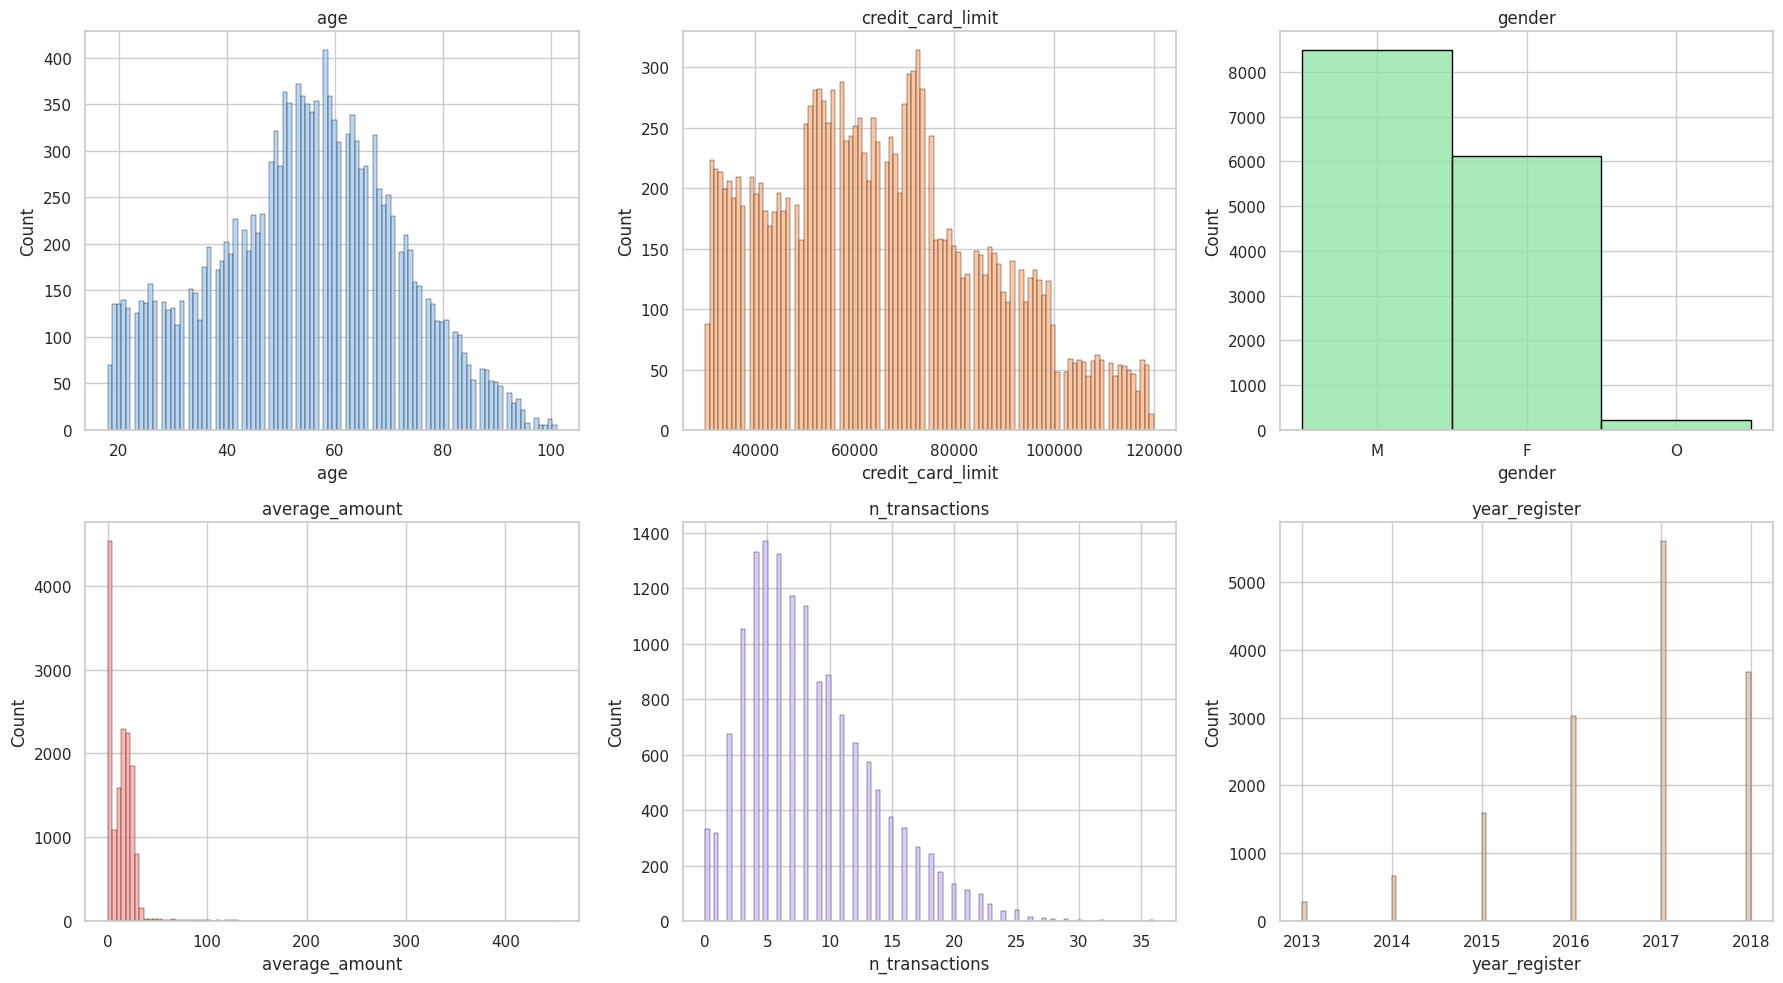

In [73]:
from pyspark.sql.functions import year

df_profile_adjusted = df_profile_adjusted.withColumn("year_register", year("registered_on"))

remove_cols = ['id', 'F', 'M', 'O', 'days_since_register', 'registered_on']
sub_profile_df = df_profile_adjusted.drop(*remove_cols)
sub_profile_pd = sub_profile_df.toPandas()

sns.set_theme(style="whitegrid")

cols = sub_profile_pd.columns
n = len(cols)
ncols = 3
nrows = (n + ncols - 1) // ncols

fig, axs = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows))
axs = axs.flatten()

for i, col in enumerate(cols):
    sns.histplot(data=sub_profile_pd, x=col, bins=100, edgecolor='black', kde=False, color=sns.color_palette("pastel")[i % len(sns.color_palette("pastel"))], ax=axs[i])
    axs[i].set_title(col)

# Remove eixos vazios se houver
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


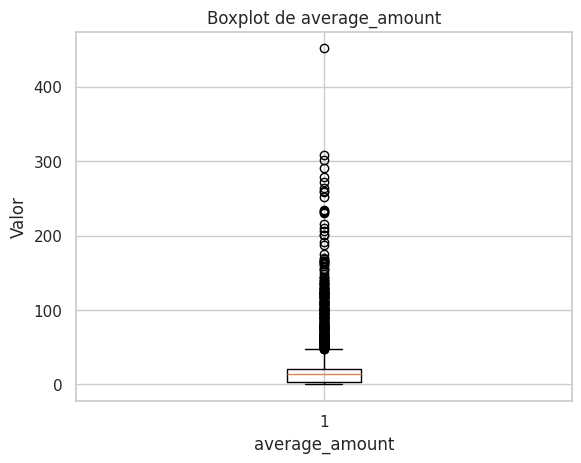

In [74]:
'''
Analisando o 'average_amount' gasto por cliente:
'''
amount_data = df_profile_adjusted.select("average_amount").dropna().rdd.flatMap(lambda x: x).collect()

plt.boxplot(amount_data)
plt.title("Boxplot de average_amount")
plt.ylabel("Valor")
plt.xlabel("average_amount")

plt.show()

In [75]:
df_profile_adjusted.select("average_amount").describe().show()


+-------+------------------+
|summary|    average_amount|
+-------+------------------+
|  count|             14825|
|   mean|14.909689404813681|
| stddev|16.511922508588807|
|    min|               0.0|
|    max|451.46999999999997|
+-------+------------------+



Com as visualizações acima, podemos ver que a maior parte dos usuários da base tem entre 50 e 60 anos. Em geral, os usuários possuem um bom limite de cartão de crédito; a maior tem entre 50 a 70 mil de limite. Boa parte dos usuários se registrou entre 2017 e 2018.

A maior quantidade de clientes é do gênero masculino, com mais de 8000 clientes, seguida por cerca de 6000 clientes do sexto feminino. Poucos clientes (menos de 500) informaram que são do gênero 'Outro'.

Em relação ao gasto médio por transação, a maior parte dos usuários gasta pouco, entre 0 a 30 reais, com média de 14.8 reais por transação. Entretanto, há muitos outliers, com alguns (poucos) usuários que gastam em média 300 reais (ou mais) por transação.

Há uma grande variação também entre o número de transações dos usuários; mas a grande maioria tem entre 4 a 8 transações durante o período coberto pela base.

### Perfis de usuário - Análise Bivariada

Para analisar a relação entre alguns pares de variáveis nos dados de perfis de usuário (Relação entre Idade e Gênero, limite no cartão de crédito e gênero, etc.), temos os plots a seguir.

<ipython-input-76-c9fec60a981d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="gender", y="age", palette="pastel", ax=axs[0, 0])
<ipython-input-76-c9fec60a981d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="gender", y="credit_card_limit", palette="pastel", ax=axs[0, 1])
<ipython-input-76-c9fec60a981d>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="gender", y="average_amount", palette="pastel", ax=axs[0, 2])


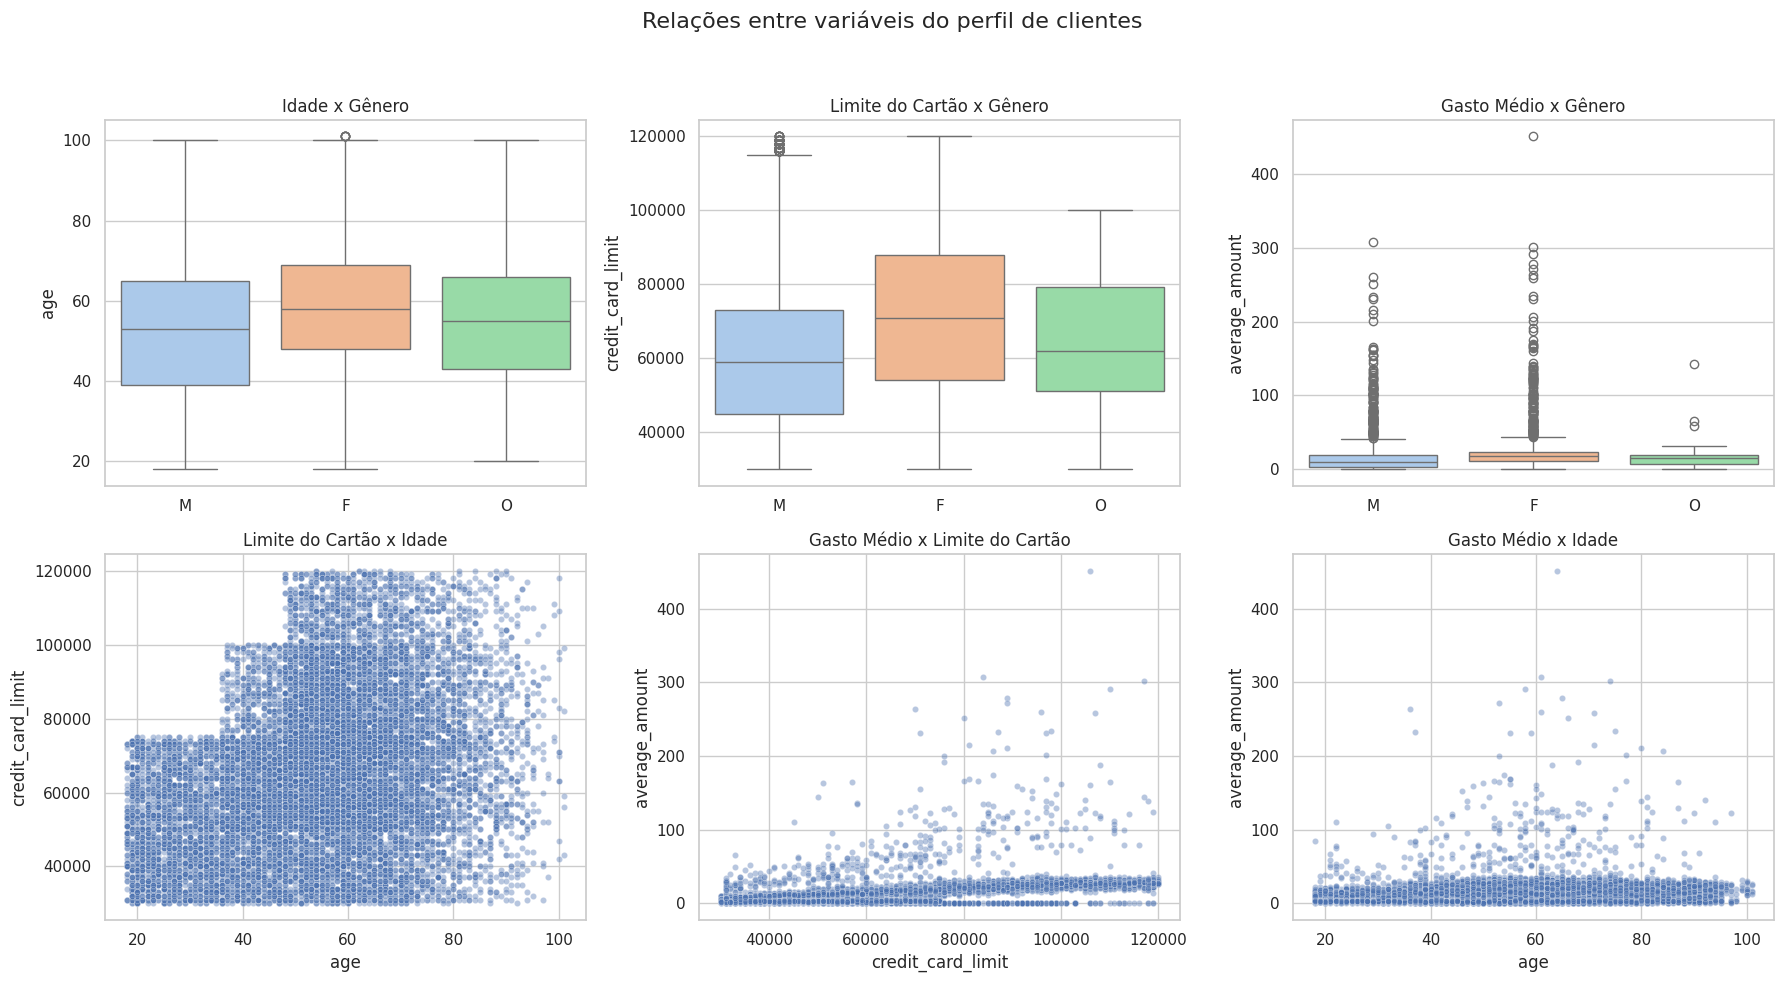

In [76]:
df = df_profile_adjusted.select("age", "credit_card_limit", "average_amount", "gender").toPandas()

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Relações entre variáveis do perfil de clientes", fontsize=16)

sns.boxplot(data=df, x="gender", y="age", palette="pastel", ax=axs[0, 0])
axs[0, 0].set_title("Idade x Gênero")
axs[0, 0].set_xlabel("")

sns.boxplot(data=df, x="gender", y="credit_card_limit", palette="pastel", ax=axs[0, 1])
axs[0, 1].set_title("Limite do Cartão x Gênero")
axs[0, 1].set_xlabel("")

sns.boxplot(data=df, x="gender", y="average_amount", palette="pastel", ax=axs[0, 2])
axs[0, 2].set_title("Gasto Médio x Gênero")
axs[0, 2].set_xlabel("")

sns.scatterplot(data=df, x="age", y="credit_card_limit", alpha=0.4, s=20, ax=axs[1, 0])
axs[1, 0].set_title("Limite do Cartão x Idade")

sns.scatterplot(data=df, x="credit_card_limit", y="average_amount", alpha=0.4, s=20, ax=axs[1, 1])
axs[1, 1].set_title("Gasto Médio x Limite do Cartão")

sns.scatterplot(data=df, x="age", y="average_amount", alpha=0.4, s=20, ax=axs[1, 2])
axs[1, 2].set_title("Gasto Médio x Idade")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Observações**
Ao ver a relação entre Gênero e Idade, vemos que todos os gêneros tem distribuições de idades parecidas, com mediana de idadde de 55 anos. A dispersão é grande, tendo usários com até 100 anos.

Ao olhar a relação entre limite do cartão e gênero, vemos que a mediana do limite das mulheres é maior que dos demais gêneros. Pessoas identificados como 'Outro' gênero tem no máximo 100k de limite, enquanto nos outros grupos, há usuários com até 120k de limite.

Em relação aos gastos médios por transação x gênero, percebemos que independente do gênero, os gastos costumam ser baixos (entre 0 e 30). Entretanto, com as mulheres, já alguns outliers, como gastos que ultrapassam 400 reais.

Em relação ao limite de cartão x idade, percebe-se que clientes entre 50 a 70 anos tendem a ter os maiores limites. Sobre o gasto médio x limite do cartão, percebe-se que independente do valor do limite, os gastos tendem a se concentrar na faixa do 0 a 30, o limite não parece impactar os gastos médios.
Em relação ao gasto médio por idade, percebe-se que, no geral, os gastos de maném entre 0 a 30 entre todas as idades, com alguns outliers aparecendo na faixa dos 60 a 70 anos. De forma silimar ao limite do cartão, a idade não parece impactar no valor do gasto médio.

**Resumo**
Gênero não parece influenciar no limite do cartão, nem nos gastos médios. A idade parece influenciar o limite do cartão.
O gasto médio aparenta ser baixo independente do gênero, idade ou limite do cartão.

### Análise Univariada - Ofertas por Cliente

Em relação às ofertas, vou verificar a distribuição de algumas variáveis de interesse.

In [77]:
'''
relembrando as colunas que tem nesse dataframe pra saber quais as que mais me interessam.
'''
df_offers_profile_adjusted.show(5)

+--------------------+--------------------+---+-----------------+------+------------------+--------------+-------------+-------------------+---+---+---+-------------+-----------+--------------+--------+---------+--------------+-------------+-------------------+-----+------+------+---+----------------+----+--------+-------------+
|            offer_id|          account_id|age|credit_card_limit|gender|    average_amount|n_transactions|registered_on|days_since_register|  F|  M|  O|time_received|time_viewed|time_completed|duration|min_value|discount_value|   offer_type|offer_name_adjusted|email|mobile|social|web|successful_offer|bogo|discount|informational|
+--------------------+--------------------+---+-----------------+------+------------------+--------------+-------------+-------------------+---+---+---+-------------+-----------+--------------+--------+---------+--------------+-------------+-------------------+-----+------+------+---+----------------+----+--------+-------------+
|3f207d

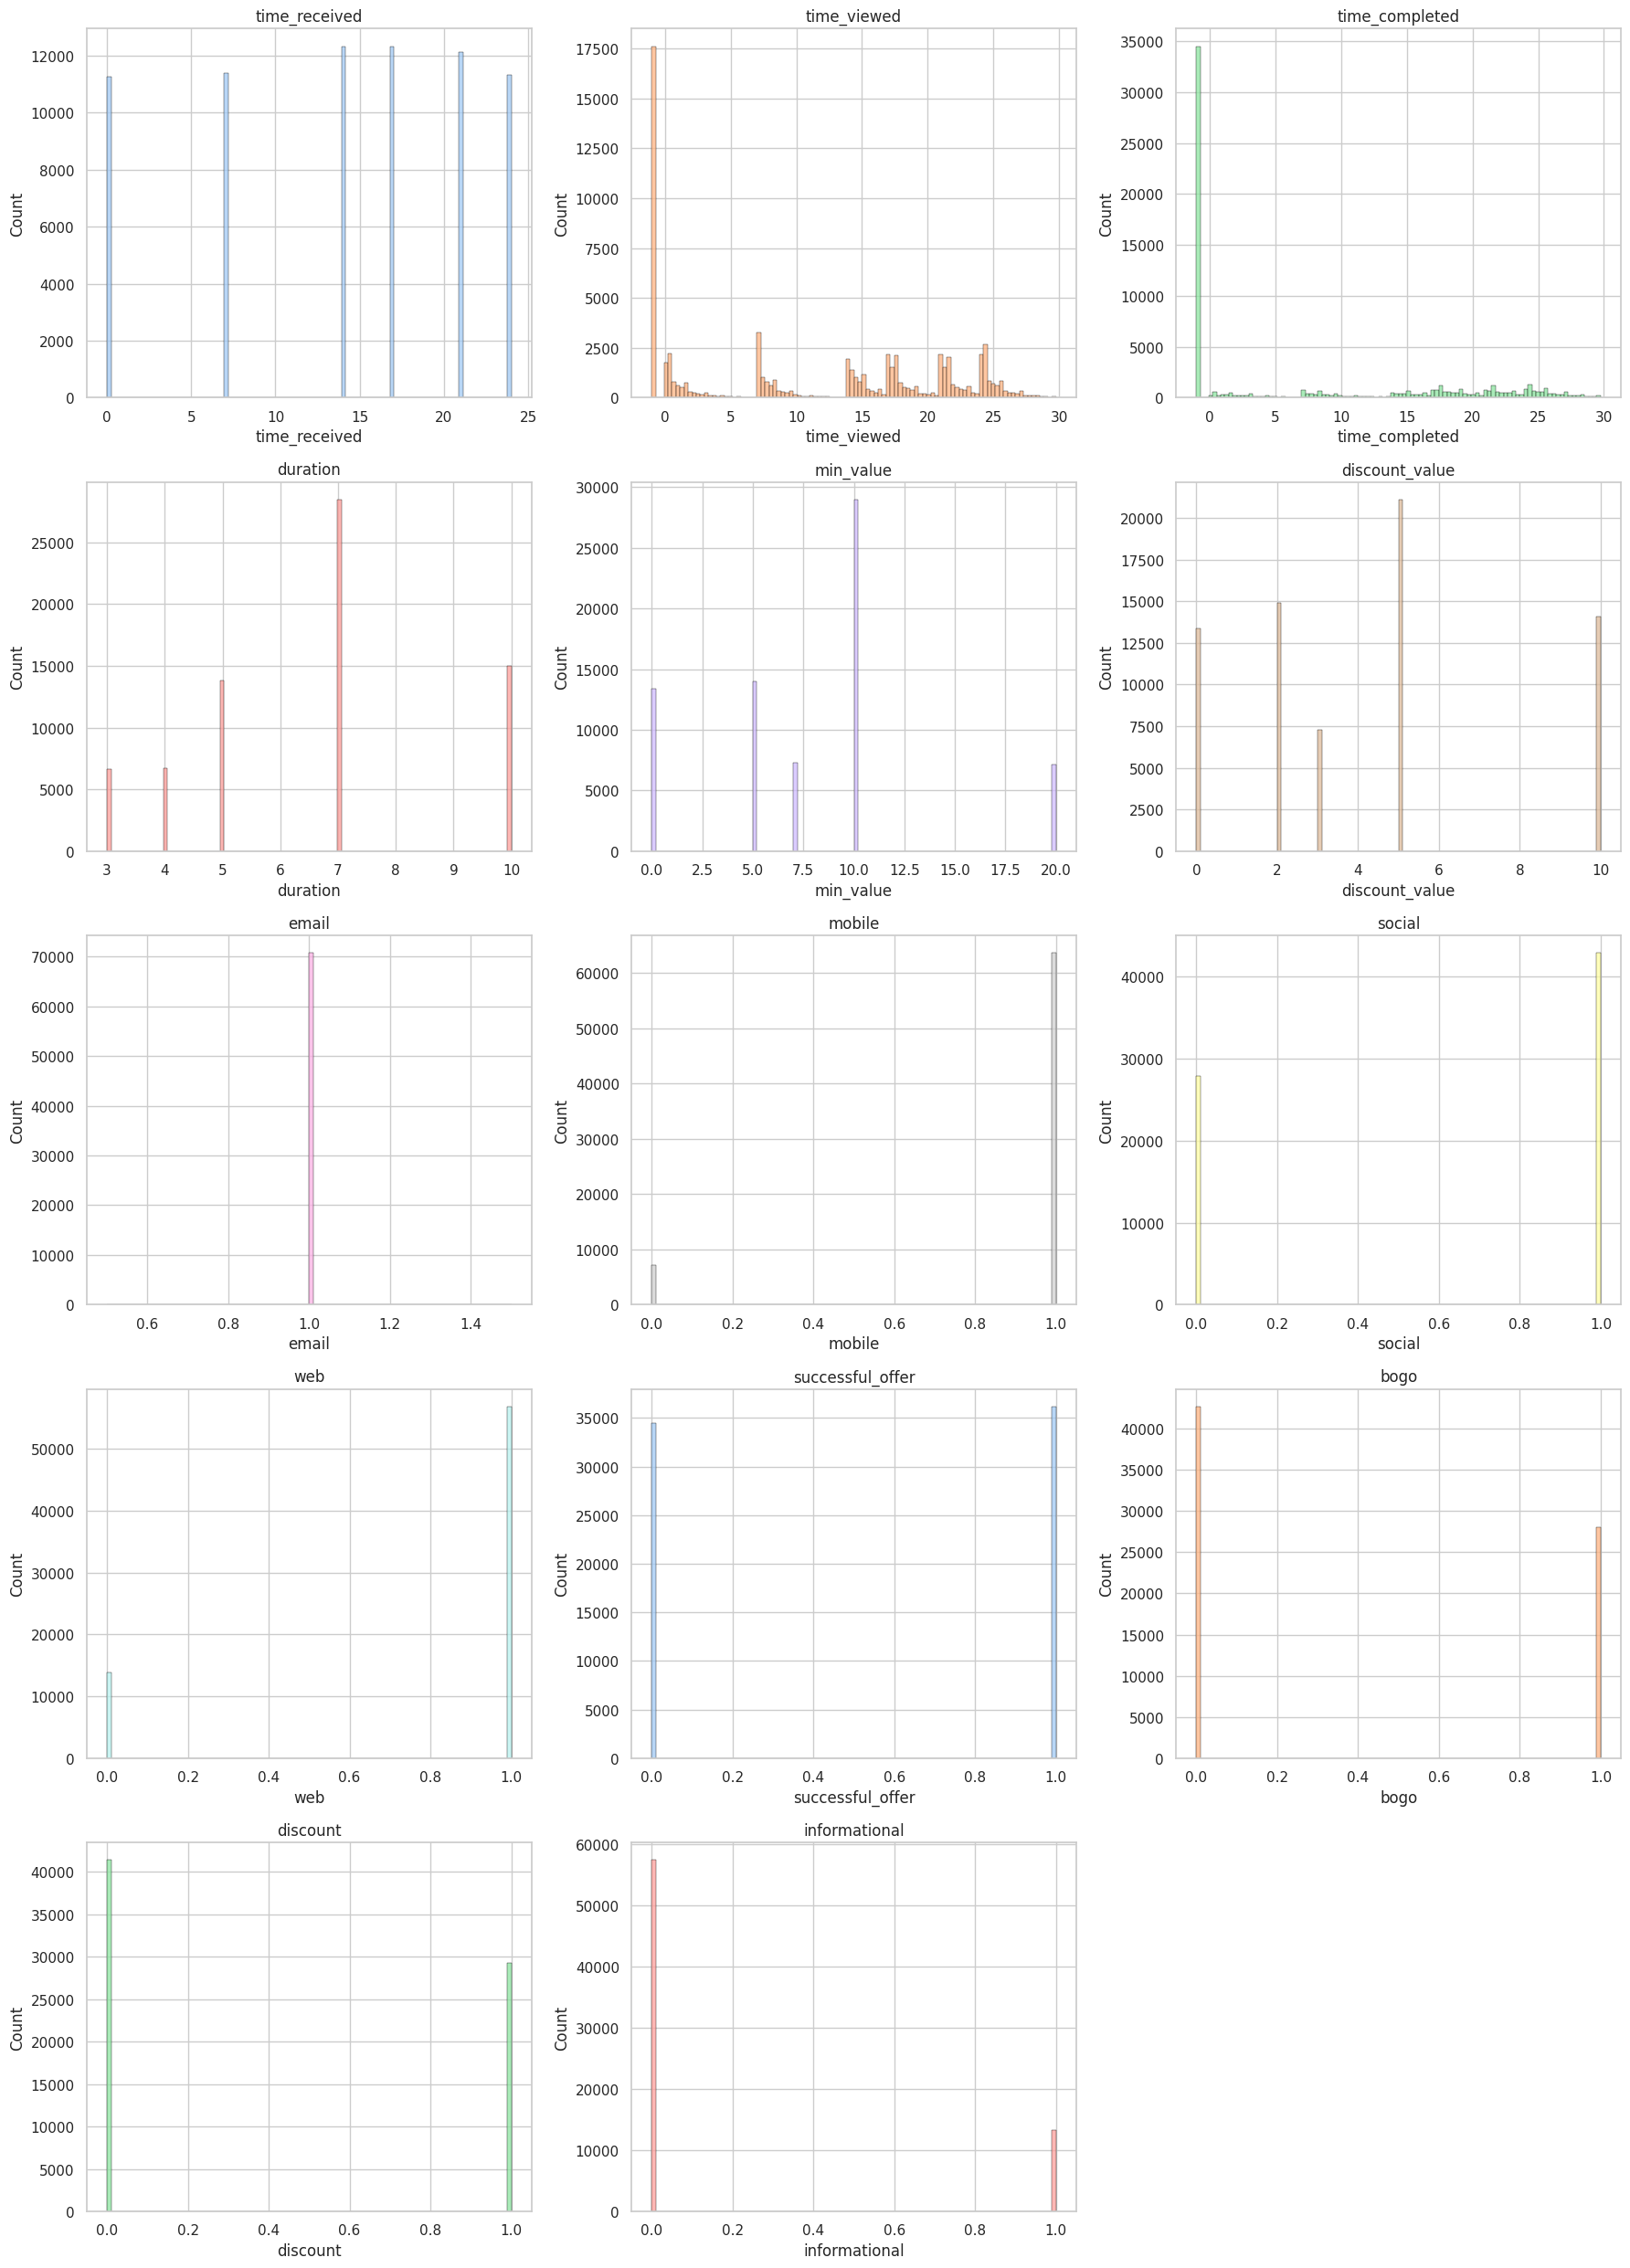

In [78]:
remove_cols = ['account_id','age','credit_card_limit', 'average_amount','n_transactions','registered_on','days_since_register','F','M','O','offer_id']
sub_offers_df = df_offers_profile_adjusted.drop(*remove_cols)
sub_offers_pd = sub_offers_df.toPandas()
sns.set_theme(style="whitegrid")

cols = sub_offers_pd.select_dtypes(include='number').columns
n = len(cols)
ncols = 3
nrows = (n + ncols - 1) // ncols

'''
criando a grade de subplots
'''
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows))
axs = axs.flatten()

'''
gerando os histogramas
'''
for i, col in enumerate(cols):
    sns.histplot(data=sub_offers_pd, x=col, bins=100, edgecolor='black',color=sns.color_palette("pastel")[i % len(sns.color_palette("pastel"))],ax=axs[i])
    axs[i].set_title(col)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


<ipython-input-79-a0d237e8566d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=offer_type_counts, x="offer_type", y="count", ax=axs[0], palette="pastel")
<ipython-input-79-a0d237e8566d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=offer_name_counts, x="offer_name_adjusted", y="count", ax=axs[1], palette="pastel")


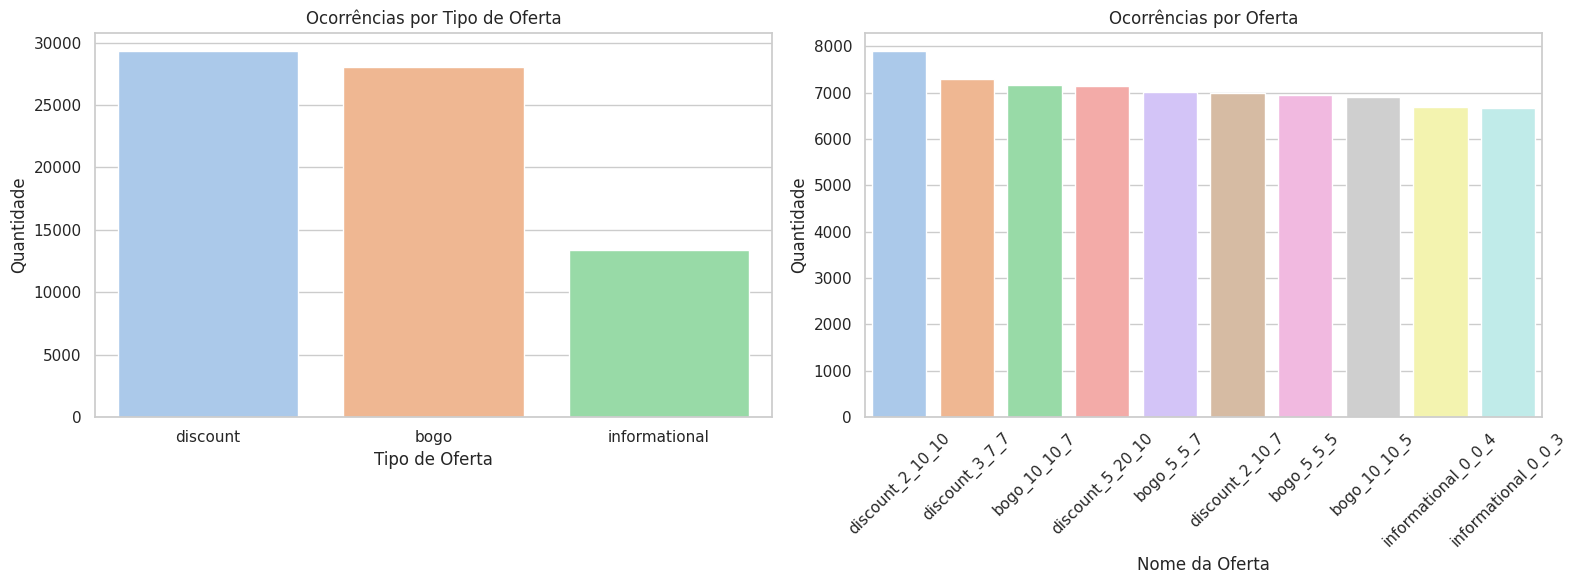

In [79]:
offer_type_counts = df_offers_profile_adjusted.groupBy("offer_type").count().toPandas().sort_values("count", ascending=False)
offer_name_counts = df_offers_profile_adjusted.groupBy("offer_name_adjusted").count().toPandas().sort_values("count", ascending=False)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(data=offer_type_counts, x="offer_type", y="count", ax=axs[0], palette="pastel")
axs[0].set_title("Ocorrências por Tipo de Oferta")
axs[0].set_xlabel("Tipo de Oferta")
axs[0].set_ylabel("Quantidade")

sns.barplot(data=offer_name_counts, x="offer_name_adjusted", y="count", ax=axs[1], palette="pastel")
axs[1].set_title("Ocorrências por Oferta")
axs[1].set_xlabel("Nome da Oferta")
axs[1].set_ylabel("Quantidade")
axs[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


**Observações**

Ao ver a distribuição dos dias em que as ofertas foram recebidas, vemos que há um balanceamente entre as datas. Já em relação ao dia que as ofertas foram vistas, grande parte delas não é vista (-1 indica que a oferta não foi visualizada). Cerca de 17k de ofertas sequer foram vistas pelos usuários, enquanto que 35k de ofertas recebidas não foram completadas pelos usuários. Para ter uma noção melhor da proporção de ofertas recebidas, vistas e completas, farei um gráfico mais a frente.

Em relação à duração das ofertas, a maior parte delas tem duração de 7 dias, enquanto que o valor mínimo mais comum para uso do cupom é 10 reais. Já o valor de desconto mais popular é o de 5 reais (assumindo qe os valores estão em reais).

Por fim, vemos que entre as ofertas aceitas ou não (successful_offer) há um balanceamento entre as classes, o que é importante para evitar viéses em um uso futuro em modelos de ML.

Em relação à distribuição das ofertas por tipo, vemos que o tipo mais comum é a oferta do tipo discount, com as ofertas específicas 'discount_2_10_10'  'discount_3_7_7' sendo as mais comuns. Ofertas do tipo 'informacional' são as menos frequentes.

### Análise Bivariada - Ofertas por Cliente

Para ver a relação entre vários atributos com o sucesso da oferta (1-aceito, 0-não aceito) e ver se existe alguma correlação entre elas, apresento as seguintes visualizações:

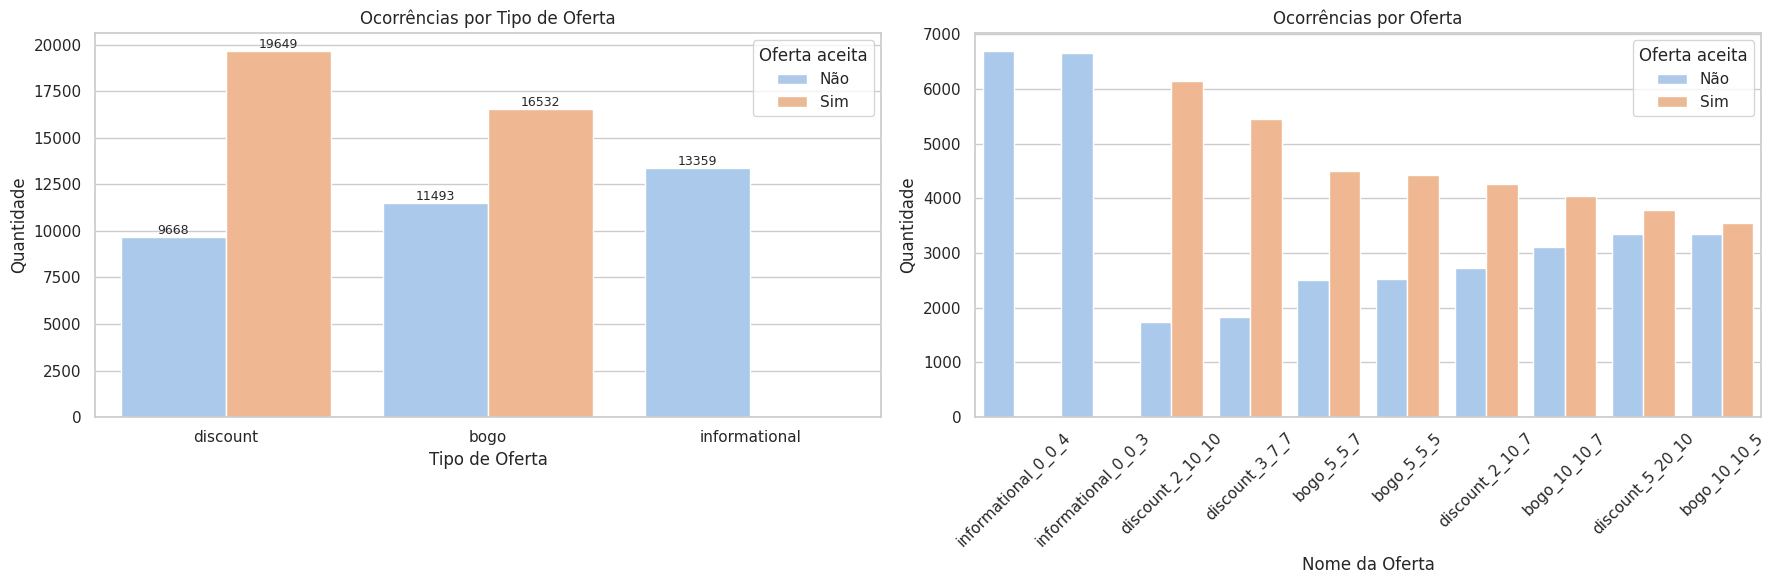

In [80]:
from matplotlib.patches import Patch

offer_type_counts = (df_offers_profile_adjusted.groupBy("offer_type","successful_offer").count().toPandas().sort_values("count", ascending=False))
offer_name_counts = (df_offers_profile_adjusted.groupBy("offer_name_adjusted","successful_offer").count().toPandas().sort_values("count", ascending=False))

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
barplot1 = sns.barplot(data=offer_type_counts,x="offer_type", y="count",hue="successful_offer",ax=axs[0], palette="pastel")
barplot2 = sns.barplot(data=offer_name_counts,x="offer_name_adjusted", y="count",hue="successful_offer",ax=axs[1], palette="pastel")

axs[0].set_title("Ocorrências por Tipo de Oferta")
axs[0].set_xlabel("Tipo de Oferta")
axs[0].set_ylabel("Quantidade")
axs[0].legend(handles=[Patch(facecolor='#AFC8E9', label='Não'),Patch(facecolor='#EAB994', label='Sim')], title="Oferta aceita")
for container in barplot1.containers:
    barplot1.bar_label(container, fmt='%.0f', label_type='edge', fontsize=9)

axs[1].set_title("Ocorrências por Oferta")
axs[1].set_xlabel("Nome da Oferta")
axs[1].set_ylabel("Quantidade")
axs[1].tick_params(axis='x', rotation=45)
axs[1].legend(handles=[Patch(facecolor='#AFC8E9', label='Não'),Patch(facecolor='#EAB994', label='Sim')], title="Oferta aceita")
for container in barplot1.containers:
    barplot2.bar_label(container, fmt='%.0f', label_type='edge', fontsize=9)


plt.tight_layout()
plt.show()


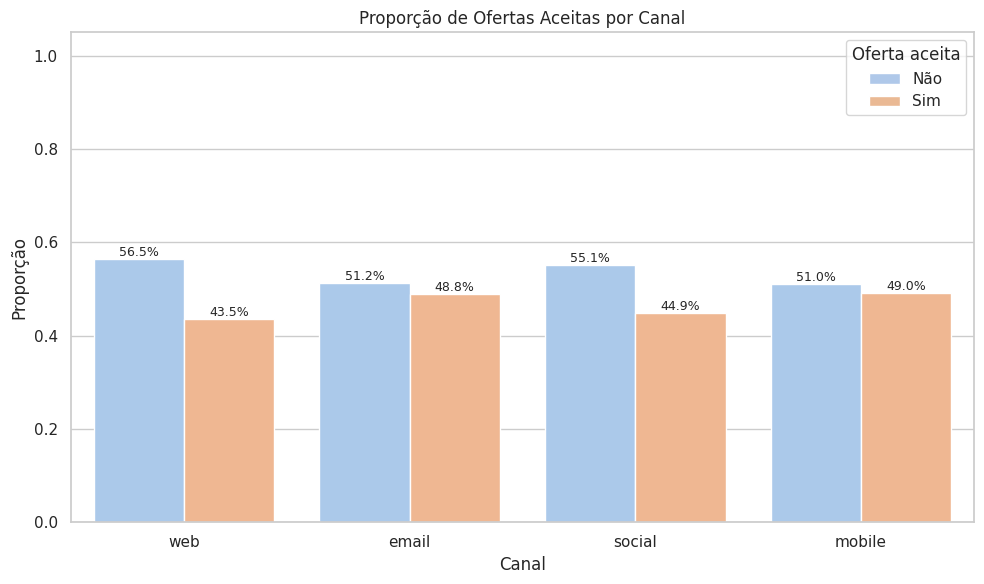

In [81]:
from pyspark.sql.functions import col, count, lit

channels = ['web', 'email', 'social', 'mobile']
dfs = []

for ch in channels:
    df_ch = df_offers_profile_adjusted.filter(col(ch) == 1).groupBy("successful_offer").agg(count("*").alias("count")).withColumn("channel", lit(ch))
    dfs.append(df_ch)
df_combined = dfs[0]
for df in dfs[1:]:
    df_combined = df_combined.unionByName(df)

df_pd = df_combined.toPandas()
df_pd["proporcao"] = df_pd.groupby("channel")["count"].transform(lambda x: x / x.sum())
df_pd["successful_offer"] = df_pd["successful_offer"].map({0: "Não aceita", 1: "Aceita"})


plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_pd, x="channel", y="proporcao", hue="successful_offer", palette="pastel")
ax.set_title("Proporção de Ofertas Aceitas por Canal")
ax.set_xlabel("Canal")
ax.set_ylabel("Proporção")
ax.set_ylim(0, 1.05)
ax.legend(handles=[Patch(facecolor='#AFC8E9', label='Não'),Patch(facecolor='#EAB994', label='Sim')], title="Oferta aceita")

for container in ax.containers:
    labels = [f"{val*100:.1f}%" if val > 0 else "" for val in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='edge', fontsize=9)

plt.tight_layout()
plt.show()


A oferta do tipo 'discount' é a mais a aceita pelos usuários, com os cupons 'discount_2_10_10' e 'discount_3_7_7' sendo os mais aceitos. As ofertas do tipo 'informational' não tem a possibilidade de serem aceitas, por isso que em ambos os gráficos, ofertas desse tipo só aparecem marcadas como 'Não'.

Quantos às ofertas aceitas por cada canal, vemos que é bem balanceado, não há um canal de envio de ofertas que é muito mais popular que outros.

<ipython-input-82-51cd50c98b77>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_grouped = age_counts.groupby(["age_range", "successful_offer"])["count"].sum().reset_index()
<ipython-input-82-51cd50c98b77>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  credit_grouped = credit_counts.groupby(["limit_range", "successful_offer"])["count"].sum().reset_index()


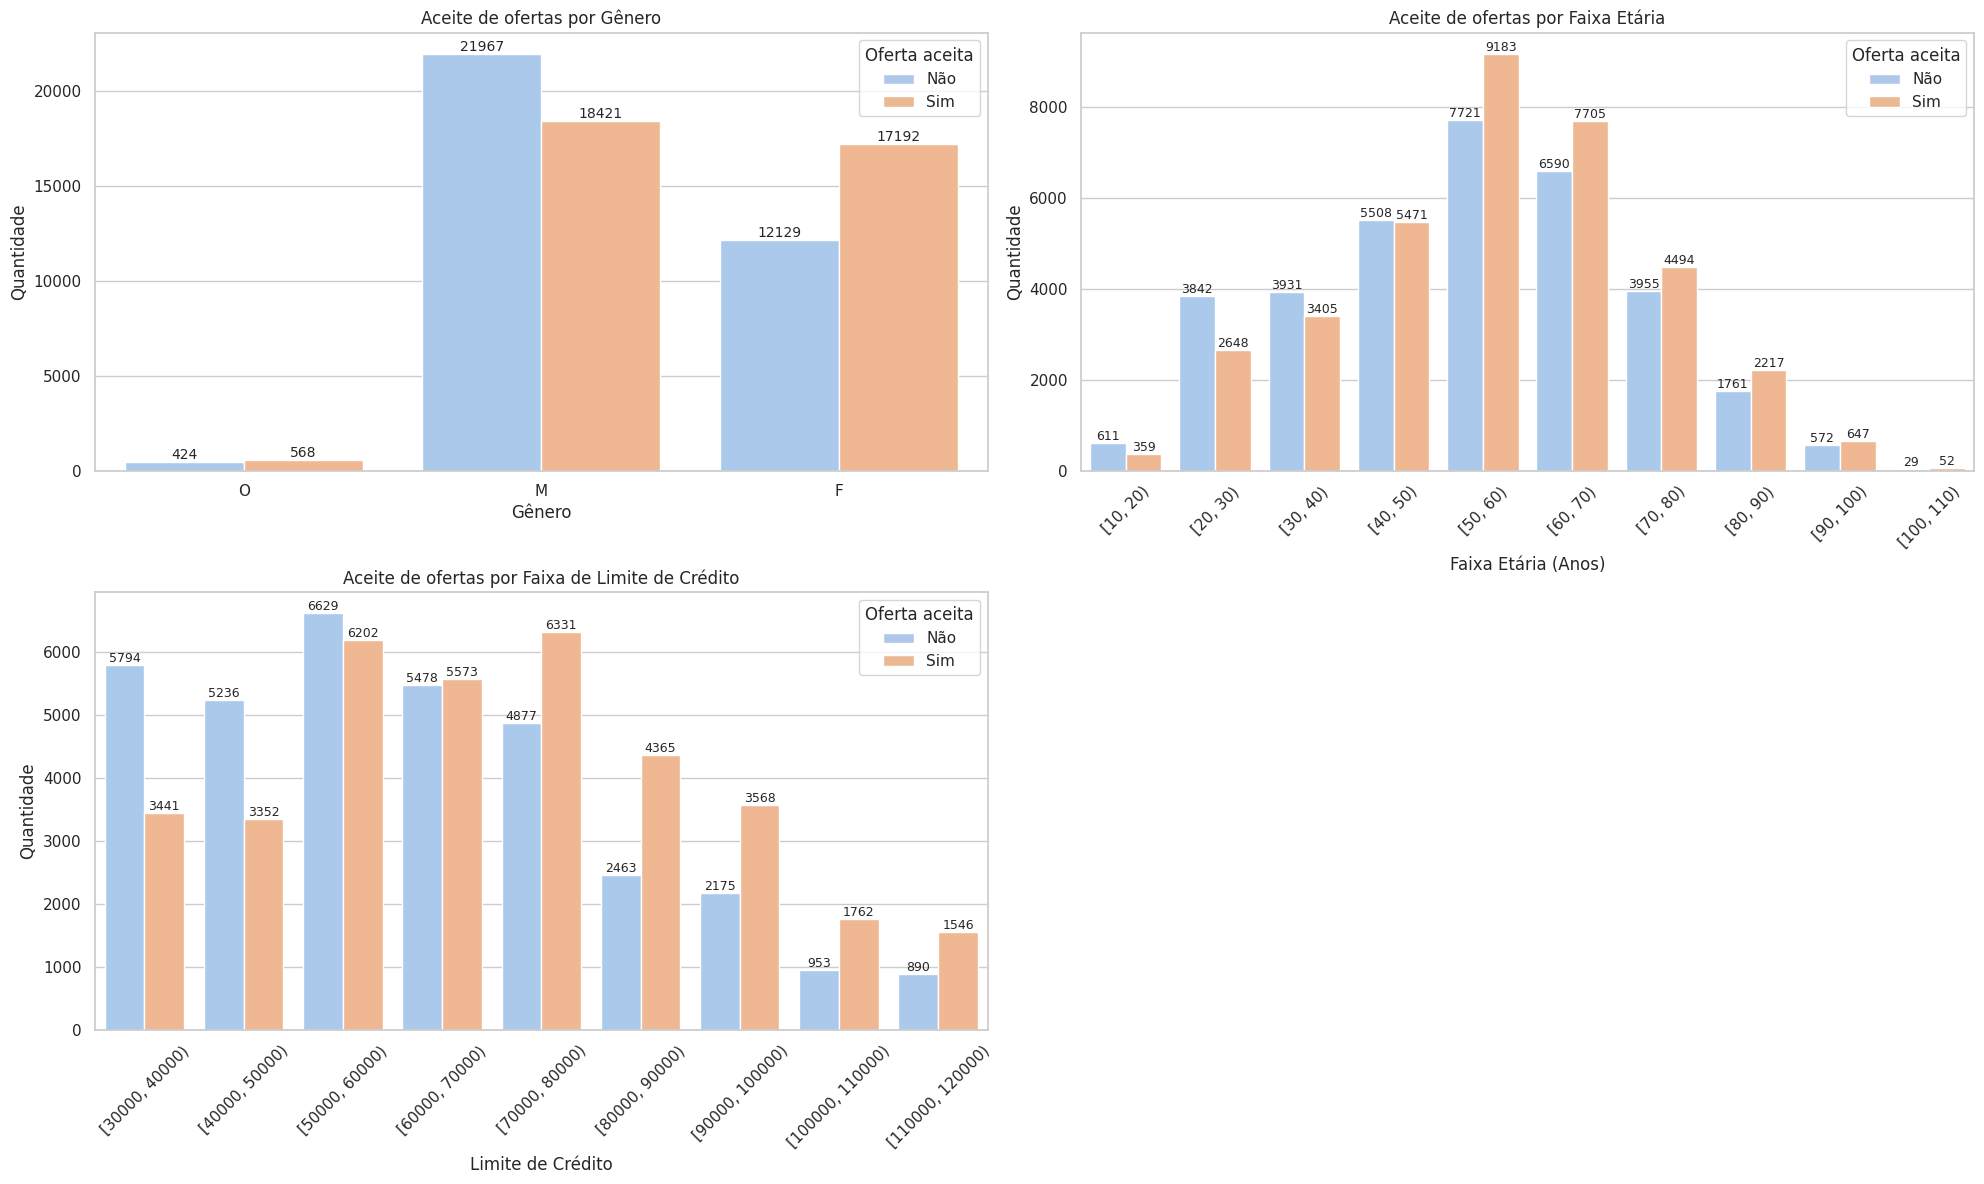

In [82]:
import pandas as pd

gender_counts = df_offers_profile_adjusted.groupBy("gender", "successful_offer").count().toPandas()

age_counts = df_offers_profile_adjusted.groupBy("age", "successful_offer").count().toPandas()
age_counts["age_range"] = pd.cut(age_counts["age"], bins=range(10, 111, 10), right=False)
age_grouped = age_counts.groupby(["age_range", "successful_offer"])["count"].sum().reset_index()

credit_counts = df_offers_profile_adjusted.groupBy("credit_card_limit", "successful_offer").count().toPandas()
min_limit = credit_counts["credit_card_limit"].min()
max_limit = credit_counts["credit_card_limit"].max()
bins = list(range(int(min_limit), int(max_limit) + 10000, 10000))
credit_counts["limit_range"] = pd.cut(credit_counts["credit_card_limit"], bins=bins, right=False)
credit_grouped = credit_counts.groupby(["limit_range", "successful_offer"])["count"].sum().reset_index()

fig, axs = plt.subplots(2, 2, figsize=(20, 12))

'''
Gênero
'''
ax = axs[0, 0]
sns.barplot(data=gender_counts, x="gender", y="count", hue="successful_offer", palette="pastel", ax=ax)
ax.set_title("Aceite de ofertas por Gênero")
ax.set_ylabel("Quantidade")
ax.set_xlabel("Gênero")
ax.legend(handles=[Patch(facecolor='#AFC8E9', label='Não'),Patch(facecolor='#EAB994', label='Sim')], title="Oferta aceita")
for c in ax.containers:
    ax.bar_label(c, fmt='%.0f', label_type='edge', fontsize=10)

'''
Faixa Etária
'''
ax = axs[0, 1]
sns.barplot(data=age_grouped, x="age_range", y="count", hue="successful_offer", palette="pastel", ax=ax)
ax.set_title("Aceite de ofertas por Faixa Etária")
ax.set_ylabel("Quantidade")
ax.set_xlabel("Faixa Etária (Anos)")
ax.tick_params(axis='x', rotation=45)
ax.legend(handles=[Patch(facecolor='#AFC8E9', label='Não'),Patch(facecolor='#EAB994', label='Sim')], title="Oferta aceita")
for c in ax.containers:
    ax.bar_label(c, fmt='%.0f', label_type='edge', fontsize=9)

'''
Faixa de Limite de Crédito
'''
ax = axs[1, 0]
sns.barplot(data=credit_grouped, x="limit_range", y="count", hue="successful_offer", palette="pastel", ax=ax)
ax.set_title("Aceite de ofertas por Faixa de Limite de Crédito")
ax.set_ylabel("Quantidade")
ax.set_xlabel("Limite de Crédito")
ax.tick_params(axis='x', rotation=45)
ax.legend(handles=[Patch(facecolor='#AFC8E9', label='Não'),Patch(facecolor='#EAB994', label='Sim')], title="Oferta aceita")
for c in ax.containers:
    ax.bar_label(c, fmt='%.0f', label_type='edge', fontsize=9)

axs[1, 1].axis('off')
plt.tight_layout()
plt.show()


**Observações**

Podemos ver que por gênero, dentro de cada grupo, mulheres e pessoas que se identificam como 'outros' aceitam mais ofertas do que rejeitam, sendo os generos mais propensos a aceitar ofertas considerando apenas o seu próprio grupo. Quando olhamos a população como um todo, os homens representam a maior parte de ofertas aceitas, porque eles são a maior parte da população, entretanto, eles mais rejeitam do que aceitam ofertas.

 Já por faixa etária, a que mais aceita cupons é a de 50-60 anos. As faixas etárias de 10 até 50 anos mais rejeitam do que aceitam ofertas. As pessoas acima de 70 tendem mais aceitar do que rejeitar ofertas.

 Ao observar as ofertas aceitas de acordo com cada faixa de limite de crédito, percebe-se que as pessoas com menos limite (entre 30k a 60k), tendem a rejeitar mais ofertas. A faixa de limites 70k a 80k é a que mais costuma aceitar ofertas.

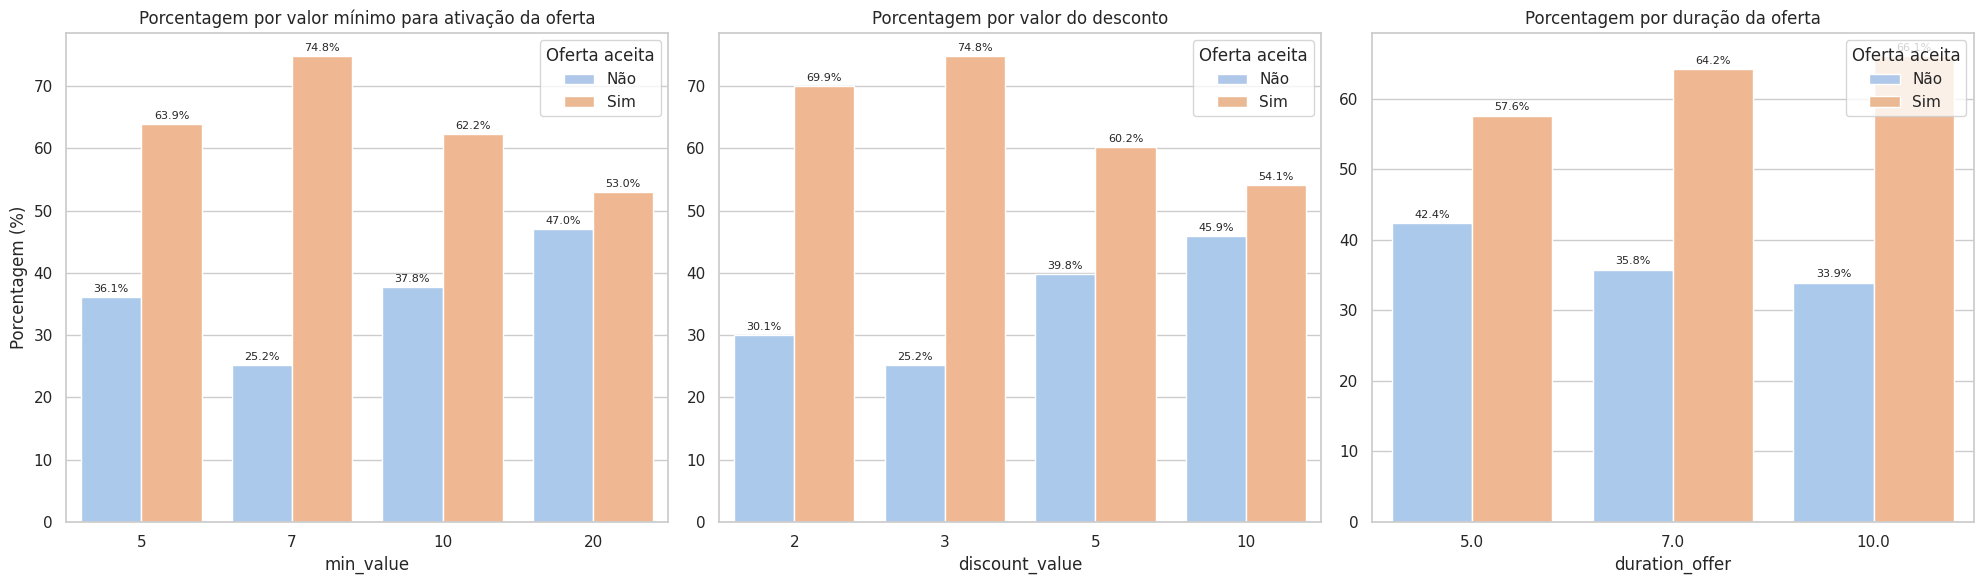

In [83]:

df_filtered = df_offers_profile_adjusted.filter(df_offers_profile_adjusted.offer_type != "informational")
minval_counts = (df_filtered.groupBy("min_value", "successful_offer").count().toPandas())
minval_counts["percentage"] = minval_counts["count"] / minval_counts.groupby("min_value")["count"].transform("sum") * 100

discount_counts = (df_filtered.groupBy("discount_value", "successful_offer").count().toPandas())
discount_counts["percentage"] = discount_counts["count"] / discount_counts.groupby("discount_value")["count"].transform("sum") * 100

duration_counts = (df_filtered.groupBy("duration", "successful_offer").count().toPandas())
duration_counts["percentage"] = duration_counts["count"] / duration_counts.groupby("duration")["count"].transform("sum") * 100

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

sns.barplot(data=minval_counts,x="min_value", y="percentage", hue="successful_offer",palette="pastel", ax=axs[0])
axs[0].set_title("Porcentagem por valor mínimo para ativação da oferta")
axs[0].set_xlabel("min_value")
axs[0].set_ylabel("Porcentagem (%)")

sns.barplot(data=discount_counts,x="discount_value", y="percentage", hue="successful_offer",palette="pastel", ax=axs[1])
axs[1].set_title("Porcentagem por valor do desconto"),
axs[1].set_xlabel("discount_value")
axs[1].set_ylabel("")

sns.barplot(data=duration_counts,x="duration", y="percentage", hue="successful_offer",palette="pastel", ax=axs[2])
axs[2].set_title("Porcentagem por duração da oferta")
axs[2].set_xlabel("duration_offer")
axs[2].set_ylabel("")

for ax in axs:
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax.text( bar.get_x() + bar.get_width() / 2,height + 0.5,f"{height:.1f}%",ha='center', va='bottom', fontsize=8)
    ax.legend(handles=[Patch(facecolor='#AFC8E9', label='Não'),Patch(facecolor='#EAB994', label='Sim')], title="Oferta aceita")
plt.tight_layout()
plt.show()


**Observações**

Ao olhar as ofertas aceitas levando em conta características como valor mínimo para uso da oferta (min_value), vemos que a oferta mais propensa a ser aceita é a que pede valor mínimo de 7 reais, sendo que a que pede o valor 20 é a menos comum de ser aceita.

Ao observar o valor do desconto, o mais aceito é o de 3 reais. Já em relação a duração das ofertas, ofertas com maior período de duração são mais aceitas, com a duração de 10 dias sendo a mais comum.

### Análise Multivariada - Ofertas por Cliente

Para ver a relação entre váras variáveis ao mesmo tempo, vou plotar um gráfico que mostra a proporção de ofertas aceitas levando em conta o gênero.

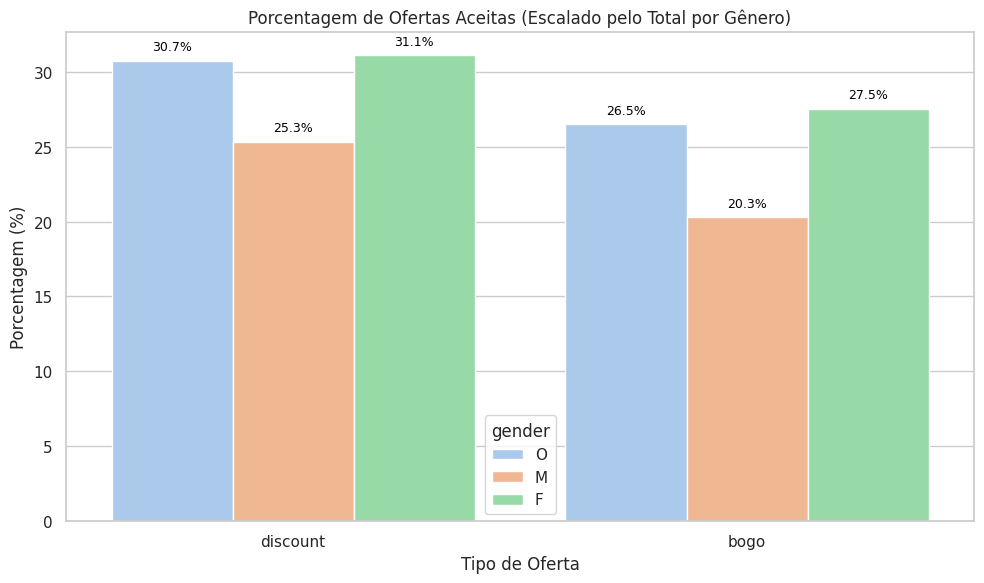

In [84]:
gender_accepted_offers = (df_offers_profile_adjusted.filter("successful_offer = 1").groupBy("offer_type", "gender").count().toPandas())
gender_totals = (df_offers_profile_adjusted.groupBy("gender").count().toPandas().set_index("gender")["count"])

gender_accepted_offers["percentage"] = gender_accepted_offers.apply(lambda row: (row["count"] / gender_totals[row["gender"]]) * 100, axis=1)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=gender_accepted_offers,x="offer_type", y="percentage", hue="gender",palette="pastel")
plt.title("Porcentagem de Ofertas Aceitas (Escalado pelo Total por Gênero)")
plt.xlabel("Tipo de Oferta")
plt.ylabel("Porcentagem (%)")

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2,height + 0.5,f"{height:.1f}%",ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()


Corroborando com o que vimos em outros plots, mulheres e pessoas que se identificam como 'outros' sãos os gêneros que mais aceitam oferta, sendo a oferta do tipo 'discount' a mais aceita.


Para analisar a proporção entre ofertas recebidas, aceitas e completas, vamos ao próximo plot.

In [85]:
result_offers.createOrReplaceTempView("offers")
df_ajusted_result_offers = spark.sql("""
SELECT *,
    CASE
        WHEN time_received != -1 THEN 1
        ELSE 0
    END AS offer_received,
    CASE
        WHEN time_viewed != -1 THEN 1
        ELSE 0
    END AS offer_viewed
FROM offers
""")
df_ajusted_result_offers.show(5)

+--------------------+--------------------+-------------+-----------+--------------+--------+---------+--------------+-------------+-------------------+-----+------+------+---+----------------+--------------+------------+
|          account_id|            offer_id|time_received|time_viewed|time_completed|duration|min_value|discount_value|   offer_type|offer_name_adjusted|email|mobile|social|web|successful_offer|offer_received|offer_viewed|
+--------------------+--------------------+-------------+-----------+--------------+--------+---------+--------------+-------------+-------------------+-----+------+------+---+----------------+--------------+------------+
|0861b9ca31b741bb8...|f19421c1d4aa40978...|          0.0|        0.0|           1.5|     5.0|        5|             5|         bogo|         bogo_5_5_5|    1|     1|     1|  1|               1|             1|           1|
|4ecbfa77f6f84e779...|3f207df678b143eea...|          0.0|       -1.0|          -1.0|     4.0|        0|         

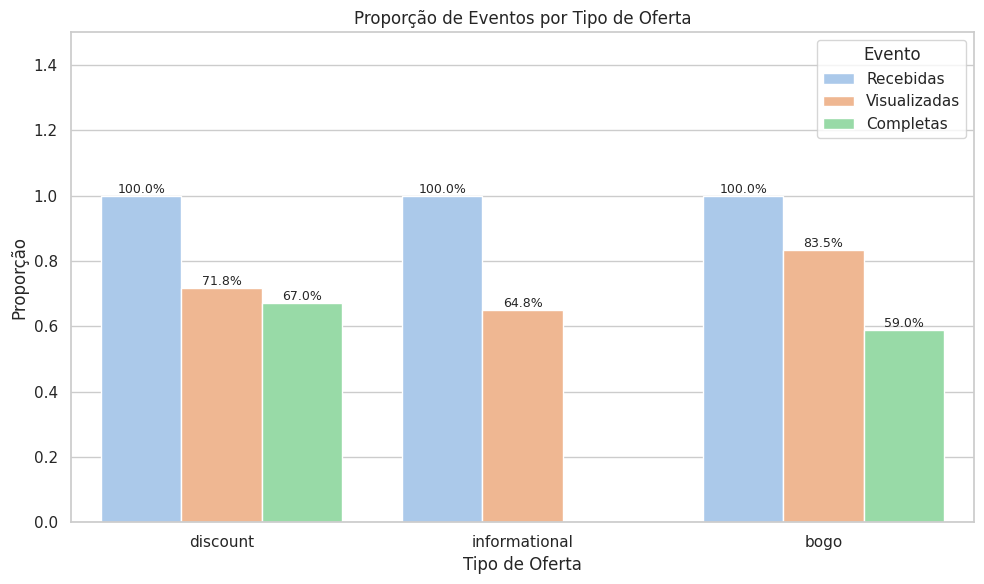

In [86]:
agg_df = df_ajusted_result_offers.groupBy("offer_type").agg(spark_sum("offer_received").alias("received"),spark_sum("offer_viewed").alias("viewed"),spark_sum("successful_offer").alias("completed"))
agg_pd = agg_df.toPandas()
agg_pd["p_received"] = 1.0 #todas as ofertas são recebidas
agg_pd["p_viewed"] = agg_pd["viewed"] / agg_pd["received"]
agg_pd["p_completed"] = agg_pd["completed"] / agg_pd["received"]

df_plot = agg_pd.melt(id_vars='offer_type',value_vars=['p_received', 'p_viewed', 'p_completed'],var_name='evento', value_name='proporcao')

df_plot["evento"] = df_plot["evento"].map({"p_received": "Recebidas","p_viewed": "Visualizadas","p_completed": "Completas"})
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_plot, x="offer_type", y="proporcao", hue="evento", palette="pastel")
plt.title("Proporção de Eventos por Tipo de Oferta")
plt.ylabel("Proporção")
plt.xlabel("Tipo de Oferta")
plt.ylim(0, 1.5)
plt.legend(title="Evento")

for container in ax.containers:
    labels = [f"{v*100:.1f}%" if v > 0 else "" for v in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='edge', fontsize=9)

plt.tight_layout()
plt.show()


Com o gráfico acima, observamos que as ofertas do tipo 'bogo' são as mais visualizadas, mas não as mais aceitas. As ofertas do tipo 'discount' são as que resultam em maior conversão (67%), já que os valores pra 'oferta visualizada' e 'oferta completa' são bem próximos.

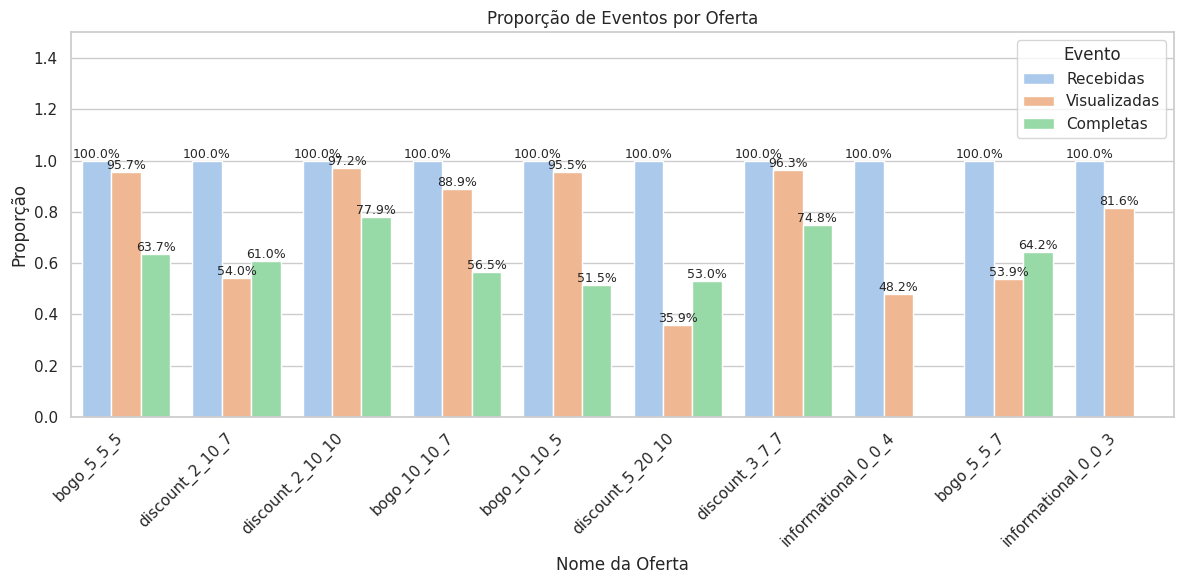

In [87]:
agg_df = df_ajusted_result_offers.groupBy("offer_name_adjusted").agg(spark_sum("offer_received").alias("received"),spark_sum("offer_viewed").alias("viewed"),spark_sum("successful_offer").alias("completed"))

agg_pd = agg_df.toPandas()
agg_pd["p_received"] = 1.0
agg_pd["p_viewed"] = agg_pd["viewed"] / agg_pd["received"]
agg_pd["p_completed"] = agg_pd["completed"] / agg_pd["received"]

df_plot = agg_pd.melt(id_vars='offer_name_adjusted',value_vars=['p_received', 'p_viewed', 'p_completed'],var_name='evento', value_name='proporcao')

df_plot["evento"] = df_plot["evento"].map({"p_received": "Recebidas","p_viewed": "Visualizadas","p_completed": "Completas"})

plt.figure(figsize=(12,6))
ax = sns.barplot(data=df_plot, x="offer_name_adjusted", y="proporcao", hue="evento", palette="pastel")
plt.title("Proporção de Eventos por Oferta")
plt.ylabel("Proporção")
plt.xlabel("Nome da Oferta")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.5)
plt.legend(title="Evento")

for container in ax.containers:
    labels = [f"{h * 100:.1f}%" if h > 0 else "" for h in container.datavalues]
    ax.bar_label(container, labels=labels, label_type="edge", fontsize=9)


plt.tight_layout()
plt.show()


Vendo cada oferta individualmente, percebe-se que algumas ofertas tem taxas de visualização bem alta, como as ofertas do tipo 'bogo' (com exceção de bogo_5_5_7), mas que isso não necessariamente reflete na completude dessas ofertas.

Por outro lado, algumas ofertas tem boas taxas de aceitação mesmo que não tenham sido vistas (discount_2_10_7). Uma oferta em específico tem uma taxa de visualização muito baixa (discount_5_20_10) o que pode levar a uma análise do porque isso acontece.

No geral, as ofertas recebidas que mais geram conversão são as do tipo 'discount', como visto em outros plots.

## Main Findings

Com base nas visualizações e conclusões anteriores, vou resumir aqui as principais observações sobre esses dados que podem ser úteis para decisões de negócio:

* A maior parte dos clientes tem entre 50 a 60 anos;

* Pessoas mais velhas (50+) tem maior taxa de aceitação de ofertas, enquanto o público mais jovem (até 40 anos) apresenta maior rejeição que aceitação;

* Homens são a maioria entre os clientes, mas eles mais rejeitam do que aceitam ofertas;

* Mulheres tem maior taxa de aceitação de ofertas e gastam mais, o que pode indicar maior engajamento do público feminino;

* Ofertas com maior duração tendem a apresentar maior taxa de aceitação;

* Ofertas com valores mínimo de uso mais acessíveis (entre 7 a 10 reais) tendem a ter maior aceitação;

* Ofertas do tipo 'discount' são as mais aceitas pelos usuários (67%);

* Ofertas do tipo 'bogo' são mais visualizadas, mas não necessariamente completadas;

* A oferta de pior desempenho foi a discount_5_20_10.